In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%tensorflow_version 1.X

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.X`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
#Installing BERT module
!pip install bert-tensorflow==1.0.1

     |████████████████████████████████| 71kB 2.9MB/s 


In [4]:
!mkdir data
!mkdir model

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

tensorflow version :  1.15.2
tensorflow_hub version :  0.10.0



## Load the data

   ID  Class                                        Description
0   0      0  從小就不喜歡牽手的寶貝每次只要一偷牽妳的手妳就會作勢要咬我但每次都是輕輕含住不會弄痛我昨天終...
1   1      0  外公因為肺癌越發嚴重的關係長期住在醫院從發病到治療大概經歷了兩年多其中時好時壞好的時候能在醫...
2   2      0  最近心情真的很糟 可能習慣了但也覺得少了一點什麼 面對親人的生離死別 真的是最痛苦的事 治療...
3   3      0  有時候叫uber結果給我來熊貓真的很嚇人熊貓外送員真的都很89很奇葩只有熊貓會一直89式的裝...
4   4      1  好幾次有輕生的想法但不希望自己離開的方式浪費社會資源憂鬱症好幾年了 嚴重到無法形容自己的狀態...
(54, 3)
**************************************************
各風險則數: 
高風險: 0 則
中風險: 27 則
低風險: 27 則
總共: 54 則


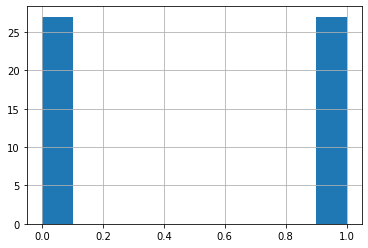

In [73]:
# Set the output directory for saving model file
OUTPUT_DIR = 'model'

data_source = "data/Dcard_1000_1091231_54.csv"

data_df = pd.read_csv(data_source, encoding='utf8', delimiter=',')
print(data_df.head())
print(data_df.shape)

print("*"*50)
print("各風險則數: ")
data_df['Class'].hist()

print(f"高風險: {data_df[data_df['Class'] == 2].shape[0]} 則") 
print(f"中風險: {data_df[data_df['Class'] == 1].shape[0]} 則") 
print(f"低風險: {data_df[data_df['Class'] == 0].shape[0]} 則")
print(f"總共: {data_df.shape[0]} 則")

## Delete stop words

In [74]:
stop_words = []
new_description_list = []

with open('./data/stop_words.txt', 'r', encoding='utf8') as f:
  for w in f.readlines():
    w = w.replace('\n', '')
    stop_words.append(w)

for index, row in data_df.iterrows():
  new_description = row['Description']
  for w in stop_words:
    new_description = new_description.replace(w,'')
  new_description_list.append(new_description)

data_df['Description'] = new_description_list

print(data_df.head())

   ID  Class                                        Description
0   0      0  從小就不喜歡牽手的寶貝每次只要一偷牽妳的手妳就會作勢要咬我但每次都是輕輕含住不會弄痛我昨天終...
1   1      0  外公因為肺癌越發嚴重的關係長期住在醫院從發病到治療大概經歷了兩年多其中時好時壞好的時候能在醫...
2   2      0  最近心情真的很糟 可能習慣了但也覺得少了一點什麼 面對親人的生離死別 真的是最痛苦的事 治療...
3   3      0  有時候叫uber結果給我來熊貓真的很嚇人熊貓外送員真的都很很奇葩只有熊貓會一直式的裝客氣假裝...
4   4      1  好幾次有輕生的想法但不希望自己離開的方式浪費社會資源憂鬱症好幾年了 嚴重到無法形容自己的狀態...


In [76]:
train, val =  train_test_split(data_df, test_size = 0.1, random_state = 200) #101 200 113 200

#Training set sample
print(train.head())

print("#"*100)
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)

print("#"*100)
print("high risk train: ",train[train['Class'] == 2].shape[0])
print("medium risk train: ",train[train['Class'] == 1].shape[0])
print("low risk train: ",train[train['Class'] == 0].shape[0])

print("high risk val: ",val[val['Class'] == 2].shape[0])
print("medium risk val: ",val[val['Class'] == 1].shape[0])
print("low risk val: ",val[val['Class'] == 0].shape[0])

    ID  Class                                        Description
5    5      1  我是留學生已經買好票聖誕節要回去原本根本不想來但學校開學前一直說會有on campus的課 ...
2    2      0  最近心情真的很糟 可能習慣了但也覺得少了一點什麼 面對親人的生離死別 真的是最痛苦的事 治療...
50  50      1                               好痛苦 好痛苦 快窒息了好想離開這個世界
17  17      0  憂鬱症的症狀我幾乎都有包括沒有目標提不起勁嗜睡想哭等等聽同學說運動可以增加多巴胺而後來我每天...
53  53      1  從高中就沒跟家裡拿過錢還有一個弟弟要養我媽身體不好精神也很不好工作斷斷續續的常常對我們又打又...
####################################################################################################
Training Set Shape : (48, 3)
Validation Set Shape : (6, 3)
####################################################################################################
high risk train:  0
medium risk train:  24
low risk train:  24
high risk val:  0
medium risk val:  3
low risk val:  3


In [77]:
DATA_COLUMN = 'Description'
LABEL_COLUMN = 'Class'
# The list containing all the classes
label_list = [0, 1, 2]

## Data preprocessing

BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:

guid : A unique id that represents an observation.  
text_a : The text we need to classify into given categories  
text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.  
label: It consists of the labels or classes or categories that a given text belongs to.  
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.

In [78]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [79]:
train_InputExamples

5     <bert.run_classifier.InputExample object at 0x...
2     <bert.run_classifier.InputExample object at 0x...
50    <bert.run_classifier.InputExample object at 0x...
17    <bert.run_classifier.InputExample object at 0x...
53    <bert.run_classifier.InputExample object at 0x...
35    <bert.run_classifier.InputExample object at 0x...
38    <bert.run_classifier.InputExample object at 0x...
45    <bert.run_classifier.InputExample object at 0x...
8     <bert.run_classifier.InputExample object at 0x...
31    <bert.run_classifier.InputExample object at 0x...
34    <bert.run_classifier.InputExample object at 0x...
33    <bert.run_classifier.InputExample object at 0x...
18    <bert.run_classifier.InputExample object at 0x...
29    <bert.run_classifier.InputExample object at 0x...
28    <bert.run_classifier.InputExample object at 0x...
0     <bert.run_classifier.InputExample object at 0x...
20    <bert.run_classifier.InputExample object at 0x...
3     <bert.run_classifier.InputExample object a

In [80]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  我是留學生已經買好票聖誕節要回去原本根本不想來但學校開學前一直說會有on campus的課 網路課會階段性取消 只好過來一直等到月初這邊疫情達到巔峰學校取消到校課程我又寫一次信問學校 因為當時我的心理狀態也已經非常不好了 我們系才終於宣布整個學期都將提供線上課程來這邊之後我個月來出門次吧 包含一開始上學拿文件月時候肚子不舒服 去藥店買藥全部都是自己騎車去 沒有搭大眾交通工具 食物都是網購或是超市送貨一拿到就在玄關消毒我的兩個室友防疫觀念很差 明明他們不需要出門但一直一直出門 找朋友來家裡玩 而且被我發現隨便拿一個口罩就重複用 硬要跟我搭話不保持社交距離 因為他們的自私和執意出門我每一次上廁所前都要用酒精消毒只敢在深夜或清晨去微波食物來吃 因為那時候我才可以不顧他們觀感的消毒空間永遠記得室友問我 為什麼那麼害怕得病的嘴臉���然而 我這麼小心足不出戶 出門也戴口罩手套 前幾天開始出現明顯怪異的症狀 但每天量體溫都沒發燒開始感覺胸悶 鼻子悶悶的後來幾天因為趕報告 比較沒有時間注意自己細微狀況還是有心臟痛 胸痛 有喘的感覺 頭痛 喉嚨有痰 一直想咳嗽 很奇怪的疲勞感 左手左腳痠痛 微波肉來吃我加了鹽跟胡椒 卻完全吃不出味道 這些症狀基本上到今天都還有 我連站著微波東西都覺得沒力氣 從下樓梯差點摔到一樓下星期就要去做pcr檢測了 陽性的話當然就是不能回去但我很害怕室友們會把我趕出去 覺得我是病毒 還有這邊的醫療應該是會叫我在家休息 到時候我該何去何從我真的好累我不想生病 我不該留學 得了病也是活該 昨天有點想要去附近的公園找一顆樹上吊 但我完全沒體力騎車出去

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  1


The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.  
check the model list here: https://tfhub.dev/s?network-architecture=transformer&publisher=google

In [81]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_chinese_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [82]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['我', '是', '留', '學', '生', '已', '經', '買', '好', '票', '聖', '誕', '節', '要', '回', '去', '原', '本', '根', '本', '不', '想', '來', '但', '學', '校', '開', '學', '前', '一', '直', '說', '會', '有', 'on', 'camp', '##us', '的', '課', '網', '路', '課', '會', '階', '段', '性', '取', '消', '只', '好', '過', '來', '一', '直', '等', '到', '月', '初', '這', '邊', '疫', '情', '達', '到', '巔', '峰', '學', '校', '取', '消', '到', '校', '課', '程', '我', '又', '寫', '一', '次', '信', '問', '學', '校', '因', '為', '當', '時', '我', '的', '心', '理', '狀', '態', '也', '已', '經', '非', '常', '不', '好', '了', '我', '們', '系', '才', '終', '於', '宣', '布', '整', '個', '學', '期', '都', '將', '提', '供', '線', '上', '課', '程', '來', '這', '邊', '之', '後', '我', '個', '月', '來', '出', '門', '次', '吧', '包', '含', '一', '開', '始', '上', '學', '拿', '文', '件', '月', '時', '候', '肚', '子', '不', '舒', '服', '去', '藥', '店', '買', '藥', '全', '部', '都', '是', '自', '己', '騎', '車', '去', '沒', '有', '搭', '大', '眾', '交', '通', '工', '具', '食', '物', '都', '是', '網', '購', '或', '是', '超', '市', '送', '貨', '一', '拿', '到', '就', '在', '玄', '關', '消', '毒', '我', '的', '兩

Format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

In [83]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 256 #128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 48


INFO:tensorflow:Writing example 0 of 48


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 我 是 留 學 生 已 經 買 好 票 聖 誕 節 要 回 去 原 本 根 本 不 想 來 但 學 校 開 學 前 一 直 說 會 有 on camp ##us 的 課 網 路 課 會 階 段 性 取 消 只 好 過 來 一 直 等 到 月 初 這 邊 疫 情 達 到 巔 峰 學 校 取 消 到 校 課 程 我 又 寫 一 次 信 問 學 校 因 為 當 時 我 的 心 理 狀 態 也 已 經 非 常 不 好 了 我 們 系 才 終 於 宣 布 整 個 學 期 都 將 提 供 線 上 課 程 來 這 邊 之 後 我 個 月 來 出 門 次 吧 包 含 一 開 始 上 學 拿 文 件 月 時 候 肚 子 不 舒 服 去 藥 店 買 藥 全 部 都 是 自 己 騎 車 去 沒 有 搭 大 眾 交 通 工 具 食 物 都 是 網 購 或 是 超 市 送 貨 一 拿 到 就 在 玄 關 消 毒 我 的 兩 個 室 友 防 疫 觀 念 很 差 明 明 他 們 不 需 要 出 門 但 一 直 一 直 出 門 找 朋 友 來 家 裡 玩 而 且 被 我 發 現 隨 便 拿 一 個 口 罩 就 重 複 用 硬 要 跟 我 搭 話 [SEP]


INFO:tensorflow:tokens: [CLS] 我 是 留 學 生 已 經 買 好 票 聖 誕 節 要 回 去 原 本 根 本 不 想 來 但 學 校 開 學 前 一 直 說 會 有 on camp ##us 的 課 網 路 課 會 階 段 性 取 消 只 好 過 來 一 直 等 到 月 初 這 邊 疫 情 達 到 巔 峰 學 校 取 消 到 校 課 程 我 又 寫 一 次 信 問 學 校 因 為 當 時 我 的 心 理 狀 態 也 已 經 非 常 不 好 了 我 們 系 才 終 於 宣 布 整 個 學 期 都 將 提 供 線 上 課 程 來 這 邊 之 後 我 個 月 來 出 門 次 吧 包 含 一 開 始 上 學 拿 文 件 月 時 候 肚 子 不 舒 服 去 藥 店 買 藥 全 部 都 是 自 己 騎 車 去 沒 有 搭 大 眾 交 通 工 具 食 物 都 是 網 購 或 是 超 市 送 貨 一 拿 到 就 在 玄 關 消 毒 我 的 兩 個 室 友 防 疫 觀 念 很 差 明 明 他 們 不 需 要 出 門 但 一 直 一 直 出 門 找 朋 友 來 家 裡 玩 而 且 被 我 發 現 隨 便 拿 一 個 口 罩 就 重 複 用 硬 要 跟 我 搭 話 [SEP]


INFO:tensorflow:input_ids: 101 2769 3221 4522 2119 4495 2347 5195 6525 1962 4873 5469 6293 5059 6206 1726 1343 1333 3315 3418 3315 679 2682 889 852 2119 3413 7274 2119 1184 671 4684 6303 3298 3300 8281 12275 8293 4638 6307 5206 6662 6307 3298 7389 3667 2595 1357 3867 1372 1962 6882 889 671 4684 5023 1168 3299 1159 6857 6920 4554 2658 6888 1168 2333 2292 2119 3413 1357 3867 1168 3413 6307 4923 2769 1348 2183 671 3613 928 1558 2119 3413 1728 4158 4534 3229 2769 4638 2552 4415 4311 2706 738 2347 5195 7478 2382 679 1962 749 2769 947 5143 2798 5173 3176 2146 2357 3146 943 2119 3309 6963 2200 2990 897 5221 677 6307 4923 889 6857 6920 722 2527 2769 943 3299 889 1139 7271 3613 1416 1259 1419 671 7274 1993 677 2119 2897 3152 816 3299 3229 952 5496 2094 679 5653 3302 1343 5973 2421 6525 5973 1059 6956 6963 3221 5632 2346 7697 6722 1343 3760 3300 3022 1920 4707 769 6858 2339 1072 7608 4289 6963 3221 5206 6554 2772 3221 6631 2356 6843 6515 671 2897 1168 2218 1762 4371 7302 3867 3681 2769 4638 1060

INFO:tensorflow:input_ids: 101 2769 3221 4522 2119 4495 2347 5195 6525 1962 4873 5469 6293 5059 6206 1726 1343 1333 3315 3418 3315 679 2682 889 852 2119 3413 7274 2119 1184 671 4684 6303 3298 3300 8281 12275 8293 4638 6307 5206 6662 6307 3298 7389 3667 2595 1357 3867 1372 1962 6882 889 671 4684 5023 1168 3299 1159 6857 6920 4554 2658 6888 1168 2333 2292 2119 3413 1357 3867 1168 3413 6307 4923 2769 1348 2183 671 3613 928 1558 2119 3413 1728 4158 4534 3229 2769 4638 2552 4415 4311 2706 738 2347 5195 7478 2382 679 1962 749 2769 947 5143 2798 5173 3176 2146 2357 3146 943 2119 3309 6963 2200 2990 897 5221 677 6307 4923 889 6857 6920 722 2527 2769 943 3299 889 1139 7271 3613 1416 1259 1419 671 7274 1993 677 2119 2897 3152 816 3299 3229 952 5496 2094 679 5653 3302 1343 5973 2421 6525 5973 1059 6956 6963 3221 5632 2346 7697 6722 1343 3760 3300 3022 1920 4707 769 6858 2339 1072 7608 4289 6963 3221 5206 6554 2772 3221 6631 2356 6843 6515 671 2897 1168 2218 1762 4371 7302 3867 3681 2769 4638 1060

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 最 近 心 情 真 的 很 糟 可 能 習 慣 了 但 也 覺 得 少 了 一 點 什 麼 面 對 親 人 的 生 離 死 別 真 的 是 最 痛 苦 的 事 治 療 那 兩 年 並 沒 哭 走 的 那 天 也 只 是 承 諾 中 哭 而 已 我 不 敢 哭 家 裡 我 排 行 老 大 我 哭 了 那 最 後 的 事 情 一 定 沒 辦 法 冷 靜 處 理 好 只 能 保 持 冷 靜 盡 量 不 碰 到 哭 點 走 的 前 一 天 也 是 輪 到 我 照 顧 的 那 天 剛 到 病 床 旁 就 被 握 住 雙 手 那 溫 暖 又 瘦 的 雙 手 緊 緊 握 住 我 那 也 是 這 麼 久 以 來 第 一 次 被 家 人 握 著 最 痛 苦 的 不 是 離 別 那 一 刻 而 是 離 別 前 的 那 個 所 有 過 程 跟 不 捨 最 難 熬 的 是 你 親 眼 看 完 整 個 過 程 一 次 次 的 化 療 一 次 次 的 抽 血 一 次 吃 的 比 一 次 少 每 個 禮 拜 回 去 有 時 在 家 修 養 有 時 卻 又 突 然 進 醫 院 加 上 那 時 又 因 為 疫 情 很 嚴 重 的 關 [SEP]


INFO:tensorflow:tokens: [CLS] 最 近 心 情 真 的 很 糟 可 能 習 慣 了 但 也 覺 得 少 了 一 點 什 麼 面 對 親 人 的 生 離 死 別 真 的 是 最 痛 苦 的 事 治 療 那 兩 年 並 沒 哭 走 的 那 天 也 只 是 承 諾 中 哭 而 已 我 不 敢 哭 家 裡 我 排 行 老 大 我 哭 了 那 最 後 的 事 情 一 定 沒 辦 法 冷 靜 處 理 好 只 能 保 持 冷 靜 盡 量 不 碰 到 哭 點 走 的 前 一 天 也 是 輪 到 我 照 顧 的 那 天 剛 到 病 床 旁 就 被 握 住 雙 手 那 溫 暖 又 瘦 的 雙 手 緊 緊 握 住 我 那 也 是 這 麼 久 以 來 第 一 次 被 家 人 握 著 最 痛 苦 的 不 是 離 別 那 一 刻 而 是 離 別 前 的 那 個 所 有 過 程 跟 不 捨 最 難 熬 的 是 你 親 眼 看 完 整 個 過 程 一 次 次 的 化 療 一 次 次 的 抽 血 一 次 吃 的 比 一 次 少 每 個 禮 拜 回 去 有 時 在 家 修 養 有 時 卻 又 突 然 進 醫 院 加 上 那 時 又 因 為 疫 情 很 嚴 重 的 關 [SEP]


INFO:tensorflow:input_ids: 101 3297 6818 2552 2658 4696 4638 2523 5136 1377 5543 5424 2715 749 852 738 6221 2533 2208 749 671 7953 784 7938 7481 2205 6217 782 4638 4495 7431 3647 1162 4696 4638 3221 3297 4578 5736 4638 752 3780 4615 6929 1060 2399 699 3760 1526 6624 4638 6929 1921 738 1372 3221 2824 6330 704 1526 5445 2347 2769 679 3140 1526 2157 6174 2769 2961 6121 5439 1920 2769 1526 749 6929 3297 2527 4638 752 2658 671 2137 3760 6794 3791 1107 7477 5993 4415 1962 1372 5543 924 2898 1107 7477 4674 7030 679 4821 1168 1526 7953 6624 4638 1184 671 1921 738 3221 6743 1168 2769 4212 7547 4638 6929 1921 1190 1168 4567 2414 3178 2218 6158 2995 857 7427 2797 6929 3984 3265 1348 4607 4638 7427 2797 5215 5215 2995 857 2769 6929 738 3221 6857 7938 719 809 889 5018 671 3613 6158 2157 782 2995 5865 3297 4578 5736 4638 679 3221 7431 1162 6929 671 1174 5445 3221 7431 1162 1184 4638 6929 943 2792 3300 6882 4923 6656 679 2943 3297 7432 4228 4638 3221 872 6217 4706 4692 2130 3146 943 6882 4923 671 361

INFO:tensorflow:input_ids: 101 3297 6818 2552 2658 4696 4638 2523 5136 1377 5543 5424 2715 749 852 738 6221 2533 2208 749 671 7953 784 7938 7481 2205 6217 782 4638 4495 7431 3647 1162 4696 4638 3221 3297 4578 5736 4638 752 3780 4615 6929 1060 2399 699 3760 1526 6624 4638 6929 1921 738 1372 3221 2824 6330 704 1526 5445 2347 2769 679 3140 1526 2157 6174 2769 2961 6121 5439 1920 2769 1526 749 6929 3297 2527 4638 752 2658 671 2137 3760 6794 3791 1107 7477 5993 4415 1962 1372 5543 924 2898 1107 7477 4674 7030 679 4821 1168 1526 7953 6624 4638 1184 671 1921 738 3221 6743 1168 2769 4212 7547 4638 6929 1921 1190 1168 4567 2414 3178 2218 6158 2995 857 7427 2797 6929 3984 3265 1348 4607 4638 7427 2797 5215 5215 2995 857 2769 6929 738 3221 6857 7938 719 809 889 5018 671 3613 6158 2157 782 2995 5865 3297 4578 5736 4638 679 3221 7431 1162 6929 671 1174 5445 3221 7431 1162 1184 4638 6929 943 2792 3300 6882 4923 6656 679 2943 3297 7432 4228 4638 3221 872 6217 4706 4692 2130 3146 943 6882 4923 671 361

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 好 痛 苦 好 痛 苦 快 窒 息 了 好 想 離 開 這 個 世 界 [SEP]


INFO:tensorflow:tokens: [CLS] 好 痛 苦 好 痛 苦 快 窒 息 了 好 想 離 開 這 個 世 界 [SEP]


INFO:tensorflow:input_ids: 101 1962 4578 5736 1962 4578 5736 2571 4966 2622 749 1962 2682 7431 7274 6857 943 686 4518 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1962 4578 5736 1962 4578 5736 2571 4966 2622 749 1962 2682 7431 7274 6857 943 686 4518 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 憂 鬱 症 的 症 狀 我 幾 乎 都 有 包 括 沒 有 目 標 提 不 起 勁 嗜 睡 想 哭 等 等 聽 同 學 說 運 動 可 以 增 加 多 巴 胺 而 後 來 我 每 天 都 會 強 迫 自 己 運 動 兩 小 時 以 上 持 續 一 個 月 了 但 好 像 沒 什 麼 用 想 說 看 能 不 能 去 輔 導 室 但 是 不 知 道 該 聊 什 麼 我 是 怕 去 了 會 讓 心 理 師 尷 尬 畢 竟 我 話 真 的 不 多 比 現 在 還 更 少 不 知 道 要 從 何 聊 起 還 是 說 心 理 師 會 主 動 問 問 題 之 類 的 有 人 有 這 方 面 的 經 驗 可 以 分 享 一 下 嗎 [SEP]


INFO:tensorflow:tokens: [CLS] 憂 鬱 症 的 症 狀 我 幾 乎 都 有 包 括 沒 有 目 標 提 不 起 勁 嗜 睡 想 哭 等 等 聽 同 學 說 運 動 可 以 增 加 多 巴 胺 而 後 來 我 每 天 都 會 強 迫 自 己 運 動 兩 小 時 以 上 持 續 一 個 月 了 但 好 像 沒 什 麼 用 想 說 看 能 不 能 去 輔 導 室 但 是 不 知 道 該 聊 什 麼 我 是 怕 去 了 會 讓 心 理 師 尷 尬 畢 竟 我 話 真 的 不 多 比 現 在 還 更 少 不 知 道 要 從 何 聊 起 還 是 說 心 理 師 會 主 動 問 問 題 之 類 的 有 人 有 這 方 面 的 經 驗 可 以 分 享 一 下 嗎 [SEP]


INFO:tensorflow:input_ids: 101 2726 7786 4568 4638 4568 4311 2769 2407 725 6963 3300 1259 2886 3760 3300 4680 3560 2990 679 6629 1233 1628 4717 2682 1526 5023 5023 5481 1398 2119 6303 6880 1240 1377 809 1872 1217 1914 2349 5542 5445 2527 889 2769 3680 1921 6963 3298 2485 6833 5632 2346 6880 1240 1060 2207 3229 809 677 2898 5265 671 943 3299 749 852 1962 1008 3760 784 7938 4500 2682 6303 4692 5543 679 5543 1343 6737 2206 2147 852 3221 679 4761 6887 6283 5464 784 7938 2769 3221 2586 1343 749 3298 6366 2552 4415 2374 2220 2217 4525 4994 2769 6282 4696 4638 679 1914 3683 4412 1762 6917 3291 2208 679 4761 6887 6206 2537 862 5464 6629 6917 3221 6303 2552 4415 2374 3298 712 1240 1558 1558 7539 722 7546 4638 3300 782 3300 6857 3175 7481 4638 5195 7710 1377 809 1146 775 671 678 1621 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2726 7786 4568 4638 4568 4311 2769 2407 725 6963 3300 1259 2886 3760 3300 4680 3560 2990 679 6629 1233 1628 4717 2682 1526 5023 5023 5481 1398 2119 6303 6880 1240 1377 809 1872 1217 1914 2349 5542 5445 2527 889 2769 3680 1921 6963 3298 2485 6833 5632 2346 6880 1240 1060 2207 3229 809 677 2898 5265 671 943 3299 749 852 1962 1008 3760 784 7938 4500 2682 6303 4692 5543 679 5543 1343 6737 2206 2147 852 3221 679 4761 6887 6283 5464 784 7938 2769 3221 2586 1343 749 3298 6366 2552 4415 2374 2220 2217 4525 4994 2769 6282 4696 4638 679 1914 3683 4412 1762 6917 3291 2208 679 4761 6887 6206 2537 862 5464 6629 6917 3221 6303 2552 4415 2374 3298 712 1240 1558 1558 7539 722 7546 4638 3300 782 3300 6857 3175 7481 4638 5195 7710 1377 809 1146 775 671 678 1621 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 從 高 中 就 沒 跟 家 裡 拿 過 錢 還 有 一 個 弟 弟 要 養 我 媽 身 體 不 好 精 神 也 很 不 好 工 作 斷 斷 續 續 的 常 常 對 我 們 又 打 又 罵 下 一 秒 又 抱 著 我 哭 國 小 開 始 就 知 道 我 跟 其 他 同 學 不 一 樣 大 家 有 的 我 什 麼 都 沒 有 每 個 禮 拜 三 的 便 服 日 都 要 說 我 喜 歡 穿 制 服 其 實 是 沒 一 件 像 樣 的 衣 服 可 以 穿 好 不 容 易 撐 到 大 學 別 人 眼 中 的 大 學 生 活 根 本 不 敢 奢 望 沒 有 社 團 沒 有 同 伴 沒 有 朋 友 我 兼 了 三 份 工 生 病 也 不 敢 看 醫 生 因 為 看 醫 生 要 花 錢 我 媽 逼 我 給 他 每 個 月 的 薪 水 如 果 不 給 他 又 會 開 始 情 緒 勒 索 但 我 是 真 的 完 全 沒 錢 了 想 到 畢 業 後 還 要 還 學 貸 還 有 媽 媽 跟 弟 弟 每 天 都 在 想 我 為 什 麼 要 身 在 這 個 家 庭 我 還 能 怎 麼 辦 有 時 候 覺 得 跳 下 去 是 不 [SEP]


INFO:tensorflow:tokens: [CLS] 從 高 中 就 沒 跟 家 裡 拿 過 錢 還 有 一 個 弟 弟 要 養 我 媽 身 體 不 好 精 神 也 很 不 好 工 作 斷 斷 續 續 的 常 常 對 我 們 又 打 又 罵 下 一 秒 又 抱 著 我 哭 國 小 開 始 就 知 道 我 跟 其 他 同 學 不 一 樣 大 家 有 的 我 什 麼 都 沒 有 每 個 禮 拜 三 的 便 服 日 都 要 說 我 喜 歡 穿 制 服 其 實 是 沒 一 件 像 樣 的 衣 服 可 以 穿 好 不 容 易 撐 到 大 學 別 人 眼 中 的 大 學 生 活 根 本 不 敢 奢 望 沒 有 社 團 沒 有 同 伴 沒 有 朋 友 我 兼 了 三 份 工 生 病 也 不 敢 看 醫 生 因 為 看 醫 生 要 花 錢 我 媽 逼 我 給 他 每 個 月 的 薪 水 如 果 不 給 他 又 會 開 始 情 緒 勒 索 但 我 是 真 的 完 全 沒 錢 了 想 到 畢 業 後 還 要 還 學 貸 還 有 媽 媽 跟 弟 弟 每 天 都 在 想 我 為 什 麼 要 身 在 這 個 家 庭 我 還 能 怎 麼 辦 有 時 候 覺 得 跳 下 去 是 不 [SEP]


INFO:tensorflow:input_ids: 101 2537 7770 704 2218 3760 6656 2157 6174 2897 6882 7092 6917 3300 671 943 2475 2475 6206 7621 2769 2061 6716 7768 679 1962 5125 4868 738 2523 679 1962 2339 868 3174 3174 5265 5265 4638 2382 2382 2205 2769 947 1348 2802 1348 5393 678 671 4907 1348 2849 5865 2769 1526 1751 2207 7274 1993 2218 4761 6887 2769 6656 1071 800 1398 2119 679 671 3564 1920 2157 3300 4638 2769 784 7938 6963 3760 3300 3680 943 4891 2876 676 4638 912 3302 3189 6963 6206 6303 2769 1599 3631 4959 1169 3302 1071 2179 3221 3760 671 816 1008 3564 4638 6132 3302 1377 809 4959 1962 679 2159 3211 3052 1168 1920 2119 1162 782 4706 704 4638 1920 2119 4495 3833 3418 3315 679 3140 1951 3307 3760 3300 4852 1757 3760 3300 1398 845 3760 3300 3301 1351 2769 1076 749 676 819 2339 4495 4567 738 679 3140 4692 7015 4495 1728 4158 4692 7015 4495 6206 5709 7092 2769 2061 6873 2769 5183 800 3680 943 3299 4638 5959 3717 1963 3362 679 5183 800 1348 3298 7274 1993 2658 5219 1239 5164 852 2769 3221 4696 4638 2130

INFO:tensorflow:input_ids: 101 2537 7770 704 2218 3760 6656 2157 6174 2897 6882 7092 6917 3300 671 943 2475 2475 6206 7621 2769 2061 6716 7768 679 1962 5125 4868 738 2523 679 1962 2339 868 3174 3174 5265 5265 4638 2382 2382 2205 2769 947 1348 2802 1348 5393 678 671 4907 1348 2849 5865 2769 1526 1751 2207 7274 1993 2218 4761 6887 2769 6656 1071 800 1398 2119 679 671 3564 1920 2157 3300 4638 2769 784 7938 6963 3760 3300 3680 943 4891 2876 676 4638 912 3302 3189 6963 6206 6303 2769 1599 3631 4959 1169 3302 1071 2179 3221 3760 671 816 1008 3564 4638 6132 3302 1377 809 4959 1962 679 2159 3211 3052 1168 1920 2119 1162 782 4706 704 4638 1920 2119 4495 3833 3418 3315 679 3140 1951 3307 3760 3300 4852 1757 3760 3300 1398 845 3760 3300 3301 1351 2769 1076 749 676 819 2339 4495 4567 738 679 3140 4692 7015 4495 1728 4158 4692 7015 4495 6206 5709 7092 2769 2061 6873 2769 5183 800 3680 943 3299 4638 5959 3717 1963 3362 679 5183 800 1348 3298 7274 1993 2658 5219 1239 5164 852 2769 3221 4696 4638 2130

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 6


INFO:tensorflow:Writing example 0 of 6


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 以 前 最 期 待 月 喜 歡 打 扮 美 美 的 跟 好 友 約 拍 網 美 照 天 氣 冷 冷 的 超 舒 服 辦 公 室 很 歡 樂 氣 氛 十 二 月 大 家 都 比 較 輕 鬆 再 長 大 後 的 十 二 月 上 班 後 變 得 又 胖 又 醜 不 打 扮 下 班 後 除 了 回 家 躺 也 沒 什 麼 力 氣 做 其 他 事 年 初 時 鼓 起 勇 氣 上 健 身 房 開 始 重 訓 竟 然 膝 蓋 受 傷 了 同 事 們 個 個 薪 水 小 偷 事 情 都 我 在 忙 一 個 抵 四 個 人 的 工 作 量 偏 偏 主 管 不 愛 我 我 只 能 做 到 死 我 在 公 司 就 是 一 個 芬 蘭 人 我 覺 得 自 己 又 肥 又 醜 走 路 頭 都 低 低 的 看 到 有 人 擋 路 中 間 還 會 等 他 們 走 在 起 身 現 在 也 感 覺 沒 朋 友 只 剩 一 個 會 出 來 吧 疑 真 的 婚 禮 我 也 不 想 辦 因 為 根 本 邀 不 到 人 會 很 糗 婚 禮 也 不 用 想 太 多 男 友 也 沒 要 娶 我 的 意 思 家 爸 媽 只 有 逼 著 我 工 作 [SEP]


INFO:tensorflow:tokens: [CLS] 以 前 最 期 待 月 喜 歡 打 扮 美 美 的 跟 好 友 約 拍 網 美 照 天 氣 冷 冷 的 超 舒 服 辦 公 室 很 歡 樂 氣 氛 十 二 月 大 家 都 比 較 輕 鬆 再 長 大 後 的 十 二 月 上 班 後 變 得 又 胖 又 醜 不 打 扮 下 班 後 除 了 回 家 躺 也 沒 什 麼 力 氣 做 其 他 事 年 初 時 鼓 起 勇 氣 上 健 身 房 開 始 重 訓 竟 然 膝 蓋 受 傷 了 同 事 們 個 個 薪 水 小 偷 事 情 都 我 在 忙 一 個 抵 四 個 人 的 工 作 量 偏 偏 主 管 不 愛 我 我 只 能 做 到 死 我 在 公 司 就 是 一 個 芬 蘭 人 我 覺 得 自 己 又 肥 又 醜 走 路 頭 都 低 低 的 看 到 有 人 擋 路 中 間 還 會 等 他 們 走 在 起 身 現 在 也 感 覺 沒 朋 友 只 剩 一 個 會 出 來 吧 疑 真 的 婚 禮 我 也 不 想 辦 因 為 根 本 邀 不 到 人 會 很 糗 婚 禮 也 不 用 想 太 多 男 友 也 沒 要 娶 我 的 意 思 家 爸 媽 只 有 逼 著 我 工 作 [SEP]


INFO:tensorflow:input_ids: 101 809 1184 3297 3309 2521 3299 1599 3631 2802 2815 5401 5401 4638 6656 1962 1351 5147 2864 5206 5401 4212 1921 3706 1107 1107 4638 6631 5653 3302 6794 1062 2147 2523 3631 3556 3706 3702 1282 753 3299 1920 2157 6963 3683 6733 6738 7777 1086 7269 1920 2527 4638 1282 753 3299 677 4408 2527 6365 2533 1348 5523 1348 7011 679 2802 2815 678 4408 2527 7370 749 1726 2157 6720 738 3760 784 7938 1213 3706 976 1071 800 752 2399 1159 3229 7961 6629 1235 3706 677 978 6716 2791 7274 1993 7028 6246 4994 4197 5607 5901 1358 1003 749 1398 752 947 943 943 5959 3717 2207 982 752 2658 6963 2769 1762 2564 671 943 2850 1724 943 782 4638 2339 868 7030 974 974 712 5052 679 2695 2769 2769 1372 5543 976 1168 3647 2769 1762 1062 1385 2218 3221 671 943 5705 5984 782 2769 6221 2533 5632 2346 1348 5503 1348 7011 6624 6662 7531 6963 856 856 4638 4692 1168 3300 782 3081 6662 704 7279 6917 3298 5023 800 947 6624 1762 6629 6716 4412 1762 738 2697 6221 3760 3301 1351 1372 1197 671 943 3298 11

INFO:tensorflow:input_ids: 101 809 1184 3297 3309 2521 3299 1599 3631 2802 2815 5401 5401 4638 6656 1962 1351 5147 2864 5206 5401 4212 1921 3706 1107 1107 4638 6631 5653 3302 6794 1062 2147 2523 3631 3556 3706 3702 1282 753 3299 1920 2157 6963 3683 6733 6738 7777 1086 7269 1920 2527 4638 1282 753 3299 677 4408 2527 6365 2533 1348 5523 1348 7011 679 2802 2815 678 4408 2527 7370 749 1726 2157 6720 738 3760 784 7938 1213 3706 976 1071 800 752 2399 1159 3229 7961 6629 1235 3706 677 978 6716 2791 7274 1993 7028 6246 4994 4197 5607 5901 1358 1003 749 1398 752 947 943 943 5959 3717 2207 982 752 2658 6963 2769 1762 2564 671 943 2850 1724 943 782 4638 2339 868 7030 974 974 712 5052 679 2695 2769 2769 1372 5543 976 1168 3647 2769 1762 1062 1385 2218 3221 671 943 5705 5984 782 2769 6221 2533 5632 2346 1348 5503 1348 7011 6624 6662 7531 6963 856 856 4638 4692 1168 3300 782 3081 6662 704 7279 6917 3298 5023 800 947 6624 1762 6629 6716 4412 1762 738 2697 6221 3760 3301 1351 1372 1197 671 943 3298 11

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 大 一 因 為 玩 了 社 團 與 系 上 朋 友 越 來 越 遙 遠 現 在 大 三 了 接 了 社 長 參 加 了 一 些 全 校 性 的 活 動 當 工 作 人 員 越 來 越 忙 碌 開 始 與 社 團 的 朋 友 越 來 越 遙 遠 因 為 接 了 全 校 性 的 表 演 合 作 對 象 頻 頻 出 包 各 種 事 情 接 踵 而 來 去 到 曾 經 讓 自 己 快 樂 的 社 團 只 剩 下 壓 力 因 為 壓 力 不 開 心 自 己 一 個 人 冷 靜 反 而 看 著 別 人 相 處 的 融 洽 身 為 社 長 的 我 只 能 默 默 的 看 著 被 排 擠 著 卻 不 知 道 該 如 何 融 入 反 而 越 來 越 痛 苦 越 來 越 想 哭 辦 活 動 上 社 課 什 麼 的 學 姐 總 有 想 法 不 給 我 台 階 下 講 她 兩 句 頂 十 句 怎 麼 辦 好 痛 苦 好 難 過 明 明 告 誡 自 己 不 要 在 把 情 緒 帶 到 社 團 卻 在 走 進 社 團 的 那 一 刻 開 始 不 經 意 的 默 默 變 嚴 肅 看 來 只 好 戴 起 口 罩 開 啟 我 的 保 [SEP]


INFO:tensorflow:tokens: [CLS] 大 一 因 為 玩 了 社 團 與 系 上 朋 友 越 來 越 遙 遠 現 在 大 三 了 接 了 社 長 參 加 了 一 些 全 校 性 的 活 動 當 工 作 人 員 越 來 越 忙 碌 開 始 與 社 團 的 朋 友 越 來 越 遙 遠 因 為 接 了 全 校 性 的 表 演 合 作 對 象 頻 頻 出 包 各 種 事 情 接 踵 而 來 去 到 曾 經 讓 自 己 快 樂 的 社 團 只 剩 下 壓 力 因 為 壓 力 不 開 心 自 己 一 個 人 冷 靜 反 而 看 著 別 人 相 處 的 融 洽 身 為 社 長 的 我 只 能 默 默 的 看 著 被 排 擠 著 卻 不 知 道 該 如 何 融 入 反 而 越 來 越 痛 苦 越 來 越 想 哭 辦 活 動 上 社 課 什 麼 的 學 姐 總 有 想 法 不 給 我 台 階 下 講 她 兩 句 頂 十 句 怎 麼 辦 好 痛 苦 好 難 過 明 明 告 誡 自 己 不 要 在 把 情 緒 帶 到 社 團 卻 在 走 進 社 團 的 那 一 刻 開 始 不 經 意 的 默 默 變 嚴 肅 看 來 只 好 戴 起 口 罩 開 啟 我 的 保 [SEP]


INFO:tensorflow:input_ids: 101 1920 671 1728 4158 4381 749 4852 1757 5645 5143 677 3301 1351 6632 889 6632 6891 6895 4412 1762 1920 676 749 2970 749 4852 7269 1347 1217 749 671 763 1059 3413 2595 4638 3833 1240 4534 2339 868 782 1519 6632 889 6632 2564 4808 7274 1993 5645 4852 1757 4638 3301 1351 6632 889 6632 6891 6895 1728 4158 2970 749 1059 3413 2595 4638 6134 4028 1394 868 2205 6496 7536 7536 1139 1259 1392 4934 752 2658 2970 6683 5445 889 1343 1168 3295 5195 6366 5632 2346 2571 3556 4638 4852 1757 1372 1197 678 1886 1213 1728 4158 1886 1213 679 7274 2552 5632 2346 671 943 782 1107 7477 1353 5445 4692 5865 1162 782 4685 5993 4638 6084 3835 6716 4158 4852 7269 4638 2769 1372 5543 7949 7949 4638 4692 5865 6158 2961 3089 5865 1320 679 4761 6887 6283 1963 862 6084 1057 1353 5445 6632 889 6632 4578 5736 6632 889 6632 2682 1526 6794 3833 1240 677 4852 6307 784 7938 4638 2119 1995 5244 3300 2682 3791 679 5183 2769 1378 7389 678 6341 1961 1060 1368 7515 1282 1368 2582 7938 6794 1962 4578 5

INFO:tensorflow:input_ids: 101 1920 671 1728 4158 4381 749 4852 1757 5645 5143 677 3301 1351 6632 889 6632 6891 6895 4412 1762 1920 676 749 2970 749 4852 7269 1347 1217 749 671 763 1059 3413 2595 4638 3833 1240 4534 2339 868 782 1519 6632 889 6632 2564 4808 7274 1993 5645 4852 1757 4638 3301 1351 6632 889 6632 6891 6895 1728 4158 2970 749 1059 3413 2595 4638 6134 4028 1394 868 2205 6496 7536 7536 1139 1259 1392 4934 752 2658 2970 6683 5445 889 1343 1168 3295 5195 6366 5632 2346 2571 3556 4638 4852 1757 1372 1197 678 1886 1213 1728 4158 1886 1213 679 7274 2552 5632 2346 671 943 782 1107 7477 1353 5445 4692 5865 1162 782 4685 5993 4638 6084 3835 6716 4158 4852 7269 4638 2769 1372 5543 7949 7949 4638 4692 5865 6158 2961 3089 5865 1320 679 4761 6887 6283 1963 862 6084 1057 1353 5445 6632 889 6632 4578 5736 6632 889 6632 2682 1526 6794 3833 1240 677 4852 6307 784 7938 4638 2119 1995 5244 3300 2682 3791 679 5183 2769 1378 7389 678 6341 1961 1060 1368 7515 1282 1368 2582 7938 6794 1962 4578 5

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 每 次 一 到 十 二 月 就 好 冷 又 很 暗 孤 單 一 人 的 時 候 心 情 總 是 格 外 憂 鬱 想 找 個 人 陪 伴 卻 都 因 為 大 家 都 在 過 各 自 的 生 活 而 很 難 找 到 聖 誕 節 跨 年 什 麼 看 著 大 家 限 時 總 是 無 法 讓 我 開 心 起 來 身 為 轉 學 生 辦 了 系 上 宿 營 認 識 了 大 家 卻 也 走 不 進 他 們 的 生 活 莫 名 其 妙 的 又 要 多 承 受 他 們 嫌 棄 自 己 沒 朋 友 的 眼 神 而 那 些 系 上 少 數 對 我 好 的 朋 友 身 邊 也 不 缺 人 每 次 都 好 想 把 g 暫 時 停 用 一 到 週 末 就 想 趕 快 回 家 躲 著 但 有 時 又 無 法 無 視 自 己 在 大 學 的 委 屈 而 對 家 人 們 強 顏 歡 笑 所 以 常 常 也 都 是 窩 在 自 己 房 間 覺 得 這 樣 的 自 己 好 糟 好 想 趕 快 度 過 月 趕 快 迎 接 寒 假 [SEP]


INFO:tensorflow:tokens: [CLS] 每 次 一 到 十 二 月 就 好 冷 又 很 暗 孤 單 一 人 的 時 候 心 情 總 是 格 外 憂 鬱 想 找 個 人 陪 伴 卻 都 因 為 大 家 都 在 過 各 自 的 生 活 而 很 難 找 到 聖 誕 節 跨 年 什 麼 看 著 大 家 限 時 總 是 無 法 讓 我 開 心 起 來 身 為 轉 學 生 辦 了 系 上 宿 營 認 識 了 大 家 卻 也 走 不 進 他 們 的 生 活 莫 名 其 妙 的 又 要 多 承 受 他 們 嫌 棄 自 己 沒 朋 友 的 眼 神 而 那 些 系 上 少 數 對 我 好 的 朋 友 身 邊 也 不 缺 人 每 次 都 好 想 把 g 暫 時 停 用 一 到 週 末 就 想 趕 快 回 家 躲 著 但 有 時 又 無 法 無 視 自 己 在 大 學 的 委 屈 而 對 家 人 們 強 顏 歡 笑 所 以 常 常 也 都 是 窩 在 自 己 房 間 覺 得 這 樣 的 自 己 好 糟 好 想 趕 快 度 過 月 趕 快 迎 接 寒 假 [SEP]


INFO:tensorflow:input_ids: 101 3680 3613 671 1168 1282 753 3299 2218 1962 1107 1348 2523 3266 2109 1606 671 782 4638 3229 952 2552 2658 5244 3221 3419 1912 2726 7786 2682 2823 943 782 7373 845 1320 6963 1728 4158 1920 2157 6963 1762 6882 1392 5632 4638 4495 3833 5445 2523 7432 2823 1168 5469 6293 5059 6659 2399 784 7938 4692 5865 1920 2157 7361 3229 5244 3221 4192 3791 6366 2769 7274 2552 6629 889 6716 4158 6752 2119 4495 6794 749 5143 677 2162 4245 6291 6352 749 1920 2157 1320 738 6624 679 6868 800 947 4638 4495 3833 5811 1399 1071 1975 4638 1348 6206 1914 2824 1358 800 947 2066 3468 5632 2346 3760 3301 1351 4638 4706 4868 5445 6929 763 5143 677 2208 3149 2205 2769 1962 4638 3301 1351 6716 6920 738 679 5375 782 3680 3613 6963 1962 2682 2828 149 3271 3229 977 4500 671 1168 6867 3314 2218 2682 6634 2571 1726 2157 6719 5865 852 3300 3229 1348 4192 3791 4192 6213 5632 2346 1762 1920 2119 4638 1999 2235 5445 2205 2157 782 947 2485 7542 3631 5010 2792 809 2382 2382 738 6963 3221 4979 1762 5

INFO:tensorflow:input_ids: 101 3680 3613 671 1168 1282 753 3299 2218 1962 1107 1348 2523 3266 2109 1606 671 782 4638 3229 952 2552 2658 5244 3221 3419 1912 2726 7786 2682 2823 943 782 7373 845 1320 6963 1728 4158 1920 2157 6963 1762 6882 1392 5632 4638 4495 3833 5445 2523 7432 2823 1168 5469 6293 5059 6659 2399 784 7938 4692 5865 1920 2157 7361 3229 5244 3221 4192 3791 6366 2769 7274 2552 6629 889 6716 4158 6752 2119 4495 6794 749 5143 677 2162 4245 6291 6352 749 1920 2157 1320 738 6624 679 6868 800 947 4638 4495 3833 5811 1399 1071 1975 4638 1348 6206 1914 2824 1358 800 947 2066 3468 5632 2346 3760 3301 1351 4638 4706 4868 5445 6929 763 5143 677 2208 3149 2205 2769 1962 4638 3301 1351 6716 6920 738 679 5375 782 3680 3613 6963 1962 2682 2828 149 3271 3229 977 4500 671 1168 6867 3314 2218 2682 6634 2571 1726 2157 6719 5865 852 3300 3229 1348 4192 3791 4192 6213 5632 2346 1762 1920 2119 4638 1999 2235 5445 2205 2157 782 947 2485 7542 3631 5010 2792 809 2382 2382 738 6963 3221 4979 1762 5

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 長 文 慎 入 自 從 我 懂 事 以 來 我 爸 媽 就 是 一 直 在 吵 架 大 概 小 學 三 年 級 開 始 就 鬧 分 居 了 雖 然 分 居 但 每 天 放 學 我 都 會 和 老 弟 一 起 到 老 媽 店 裡 吃 飯 老 媽 也 不 是 說 只 會 餵 飽 我 們 基 本 上 我 和 弟 弟 的 學 費 還 有 生 活 開 銷 都 是 老 媽 一 肩 扛 起 這 邊 一 定 會 有 人 問 說 我 爸 在 幹 嘛 對 我 以 前 也 覺 得 我 爸 很 廢 但 我 爸 也 不 是 無 所 事 事 他 有 在 賺 錢 但 真 的 賺 不 多 他 能 給 我 的 就 是 教 我 怎 麼 獨 立 怎 麼 做 人 雖 然 偶 爾 會 因 為 沒 洗 碗 半 夜 被 老 爸 用 水 管 打 起 來 但 多 虧 他 我 現 在 的 意 志 力 才 這 麼 堅 強 欸 先 聲 明 我 不 是 [UNK] 就 這 樣 到 了 國 二 我 因 為 某 些 原 因 和 老 爸 吵 架 離 家 出 走 去 老 媽 那 邊 後 來 他 們 就 開 始 談 離 婚 了 當 時 的 情 形 是 老 媽 想 離 老 爸 [SEP]


INFO:tensorflow:tokens: [CLS] 長 文 慎 入 自 從 我 懂 事 以 來 我 爸 媽 就 是 一 直 在 吵 架 大 概 小 學 三 年 級 開 始 就 鬧 分 居 了 雖 然 分 居 但 每 天 放 學 我 都 會 和 老 弟 一 起 到 老 媽 店 裡 吃 飯 老 媽 也 不 是 說 只 會 餵 飽 我 們 基 本 上 我 和 弟 弟 的 學 費 還 有 生 活 開 銷 都 是 老 媽 一 肩 扛 起 這 邊 一 定 會 有 人 問 說 我 爸 在 幹 嘛 對 我 以 前 也 覺 得 我 爸 很 廢 但 我 爸 也 不 是 無 所 事 事 他 有 在 賺 錢 但 真 的 賺 不 多 他 能 給 我 的 就 是 教 我 怎 麼 獨 立 怎 麼 做 人 雖 然 偶 爾 會 因 為 沒 洗 碗 半 夜 被 老 爸 用 水 管 打 起 來 但 多 虧 他 我 現 在 的 意 志 力 才 這 麼 堅 強 欸 先 聲 明 我 不 是 [UNK] 就 這 樣 到 了 國 二 我 因 為 某 些 原 因 和 老 爸 吵 架 離 家 出 走 去 老 媽 那 邊 後 來 他 們 就 開 始 談 離 婚 了 當 時 的 情 形 是 老 媽 想 離 老 爸 [SEP]


INFO:tensorflow:input_ids: 101 7269 3152 2708 1057 5632 2537 2769 2743 752 809 889 2769 4268 2061 2218 3221 671 4684 1762 1427 3373 1920 3519 2207 2119 676 2399 5159 7274 1993 2218 7785 1146 2233 749 7426 4197 1146 2233 852 3680 1921 3123 2119 2769 6963 3298 1469 5439 2475 671 6629 1168 5439 2061 2421 6174 1391 7613 5439 2061 738 679 3221 6303 1372 3298 7633 7616 2769 947 1825 3315 677 2769 1469 2475 2475 4638 2119 6527 6917 3300 4495 3833 7274 7077 6963 3221 5439 2061 671 5504 2806 6629 6857 6920 671 2137 3298 3300 782 1558 6303 2769 4268 1762 2402 1658 2205 2769 809 1184 738 6221 2533 2769 4268 2523 2450 852 2769 4268 738 679 3221 4192 2792 752 752 800 3300 1762 6553 7092 852 4696 4638 6553 679 1914 800 5543 5183 2769 4638 2218 3221 3136 2769 2582 7938 4360 4989 2582 7938 976 782 7426 4197 981 4273 3298 1728 4158 3760 3819 4813 1288 1915 6158 5439 4268 4500 3717 5052 2802 6629 889 852 1914 6000 800 2769 4412 1762 4638 2692 2562 1213 2798 6857 7938 1830 2485 3618 1044 5476 3209 2769 6

INFO:tensorflow:input_ids: 101 7269 3152 2708 1057 5632 2537 2769 2743 752 809 889 2769 4268 2061 2218 3221 671 4684 1762 1427 3373 1920 3519 2207 2119 676 2399 5159 7274 1993 2218 7785 1146 2233 749 7426 4197 1146 2233 852 3680 1921 3123 2119 2769 6963 3298 1469 5439 2475 671 6629 1168 5439 2061 2421 6174 1391 7613 5439 2061 738 679 3221 6303 1372 3298 7633 7616 2769 947 1825 3315 677 2769 1469 2475 2475 4638 2119 6527 6917 3300 4495 3833 7274 7077 6963 3221 5439 2061 671 5504 2806 6629 6857 6920 671 2137 3298 3300 782 1558 6303 2769 4268 1762 2402 1658 2205 2769 809 1184 738 6221 2533 2769 4268 2523 2450 852 2769 4268 738 679 3221 4192 2792 752 752 800 3300 1762 6553 7092 852 4696 4638 6553 679 1914 800 5543 5183 2769 4638 2218 3221 3136 2769 2582 7938 4360 4989 2582 7938 976 782 7426 4197 981 4273 3298 1728 4158 3760 3819 4813 1288 1915 6158 5439 4268 4500 3717 5052 2802 6629 889 852 1914 6000 800 2769 4412 1762 4638 2692 2562 1213 2798 6857 7938 1830 2485 3618 1044 5476 3209 2769 6

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 我 最 近 活 的 好 痛 苦 久 病 纏 身 又 得 不 到 家 人 支 持 後 著 臉 皮 跟 人 借 了 萬 獨 自 去 開 刀 住 了 天 院 還 手 術 失 敗 我 實 在 沒 錢 再 做 第 二 次 手 術 現 在 健 康 還 沒 恢 復 也 無 法 工 作 賺 錢 家 人 從 小 就 不 愛 我 對 我 姐 我 弟 超 好 對 我 處 處 計 較 連 我 病 成 這 樣 也 是 只 會 嫌 我 不 願 意 幫 任 何 忙 我 甚 至 連 拿 家 裡 礦 泉 水 都 要 罵 我 要 我 自 己 煮 真 不 懂 當 初 我 媽 不 該 把 我 生 下 來 的 我 姐 我 弟 生 活 費 所 有 都 家 裡 支 付 對 他 們 好 的 要 命 不 敢 對 他 們 大 聲 很 怕 他 們 生 氣 對 我 處 處 計 較 錢 之 前 甚 至 誇 張 到 煮 飯 也 不 煮 我 的 份 我 實 在 活 的 很 痛 苦 這 兩 三 年 生 病 狀 況 不 好 已 經 身 心 俱 疲 ㄧ 直 無 法 工 作 在 花 積 蓄 繳 房 租 生 活 費 還 好 我 從 小 不 靠 家 裡 很 會 賺 錢 但 [SEP]


INFO:tensorflow:tokens: [CLS] 我 最 近 活 的 好 痛 苦 久 病 纏 身 又 得 不 到 家 人 支 持 後 著 臉 皮 跟 人 借 了 萬 獨 自 去 開 刀 住 了 天 院 還 手 術 失 敗 我 實 在 沒 錢 再 做 第 二 次 手 術 現 在 健 康 還 沒 恢 復 也 無 法 工 作 賺 錢 家 人 從 小 就 不 愛 我 對 我 姐 我 弟 超 好 對 我 處 處 計 較 連 我 病 成 這 樣 也 是 只 會 嫌 我 不 願 意 幫 任 何 忙 我 甚 至 連 拿 家 裡 礦 泉 水 都 要 罵 我 要 我 自 己 煮 真 不 懂 當 初 我 媽 不 該 把 我 生 下 來 的 我 姐 我 弟 生 活 費 所 有 都 家 裡 支 付 對 他 們 好 的 要 命 不 敢 對 他 們 大 聲 很 怕 他 們 生 氣 對 我 處 處 計 較 錢 之 前 甚 至 誇 張 到 煮 飯 也 不 煮 我 的 份 我 實 在 活 的 很 痛 苦 這 兩 三 年 生 病 狀 況 不 好 已 經 身 心 俱 疲 ㄧ 直 無 法 工 作 在 花 積 蓄 繳 房 租 生 活 費 還 好 我 從 小 不 靠 家 裡 很 會 賺 錢 但 [SEP]


INFO:tensorflow:input_ids: 101 2769 3297 6818 3833 4638 1962 4578 5736 719 4567 5267 6716 1348 2533 679 1168 2157 782 3118 2898 2527 5865 5622 4649 6656 782 955 749 5857 4360 5632 1343 7274 1143 857 749 1921 7368 6917 2797 6123 1927 3134 2769 2179 1762 3760 7092 1086 976 5018 753 3613 2797 6123 4412 1762 978 2434 6917 3760 2612 2541 738 4192 3791 2339 868 6553 7092 2157 782 2537 2207 2218 679 2695 2769 2205 2769 1995 2769 2475 6631 1962 2205 2769 5993 5993 6243 6733 6865 2769 4567 2768 6857 3564 738 3221 1372 3298 2066 2769 679 7544 2692 2396 818 862 2564 2769 4493 5635 6865 2897 2157 6174 4846 3787 3717 6963 6206 5393 2769 6206 2769 5632 2346 4215 4696 679 2743 4534 1159 2769 2061 679 6283 2828 2769 4495 678 889 4638 2769 1995 2769 2475 4495 3833 6527 2792 3300 6963 2157 6174 3118 802 2205 800 947 1962 4638 6206 1462 679 3140 2205 800 947 1920 5476 2523 2586 800 947 4495 3706 2205 2769 5993 5993 6243 6733 7092 722 1184 4493 5635 6288 2484 1168 4215 7613 738 679 4215 2769 4638 819 2769

INFO:tensorflow:input_ids: 101 2769 3297 6818 3833 4638 1962 4578 5736 719 4567 5267 6716 1348 2533 679 1168 2157 782 3118 2898 2527 5865 5622 4649 6656 782 955 749 5857 4360 5632 1343 7274 1143 857 749 1921 7368 6917 2797 6123 1927 3134 2769 2179 1762 3760 7092 1086 976 5018 753 3613 2797 6123 4412 1762 978 2434 6917 3760 2612 2541 738 4192 3791 2339 868 6553 7092 2157 782 2537 2207 2218 679 2695 2769 2205 2769 1995 2769 2475 6631 1962 2205 2769 5993 5993 6243 6733 6865 2769 4567 2768 6857 3564 738 3221 1372 3298 2066 2769 679 7544 2692 2396 818 862 2564 2769 4493 5635 6865 2897 2157 6174 4846 3787 3717 6963 6206 5393 2769 6206 2769 5632 2346 4215 4696 679 2743 4534 1159 2769 2061 679 6283 2828 2769 4495 678 889 4638 2769 1995 2769 2475 4495 3833 6527 2792 3300 6963 2157 6174 3118 802 2205 800 947 1962 4638 6206 1462 679 3140 2205 800 947 1920 5476 2523 2586 800 947 4495 3706 2205 2769 5993 5993 6243 6733 7092 722 1184 4493 5635 6288 2484 1168 4215 7613 738 679 4215 2769 4638 819 2769

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [84]:
print(len(train_features))
print(len(val_features))

48
6


## Create multi-class classifier model

In [85]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [86]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(label_ids, predicted_labels)
        precision = tf.metrics.precision(label_ids, predicted_labels)
        auc = tf.metrics.auc(label_ids, predicted_labels)

        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [87]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 6.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [88]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f73a4c9ac50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f73a4c9ac50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [89]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

## Load the trained checkpoint

In [90]:
# !cp ../drive/My\ Drive/Colab\ data/BERT/BERTmodel.tar.gz .
# !tar -xf BERTmodel.tar.gz

## Training and evaluating

In [91]:
!rm -r model

In [92]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:loss = 1.6594427, step = 0


INFO:tensorflow:loss = 1.6594427, step = 0


INFO:tensorflow:Saving checkpoints for 9 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9 into model/model.ckpt.


INFO:tensorflow:Loss for final step: 0.7519512.


INFO:tensorflow:Loss for final step: 0.7519512.


Training took time  0:02:49.726036


In [93]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T07:19:58Z


INFO:tensorflow:Starting evaluation at 2021-01-05T07:19:58Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-9


INFO:tensorflow:Restoring parameters from model/model.ckpt-9


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-01-05-07:20:05


INFO:tensorflow:Finished evaluation at 2021-01-05-07:20:05


INFO:tensorflow:Saving dict for global step 9: AUC = 0.5, Precision = 0.0, Recall = 0.0, eval_accuracy = 0.5, false_negatives = 3.0, false_positives = 0.0, global_step = 9, loss = 0.7593798, true_negatives = 3.0, true_positives = 0.0


INFO:tensorflow:Saving dict for global step 9: AUC = 0.5, Precision = 0.0, Recall = 0.0, eval_accuracy = 0.5, false_negatives = 3.0, false_positives = 0.0, global_step = 9, loss = 0.7593798, true_negatives = 3.0, true_positives = 0.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9: model/model.ckpt-9


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9: model/model.ckpt-9


{'AUC': 0.5,
 'Precision': 0.0,
 'Recall': 0.0,
 'eval_accuracy': 0.5,
 'false_negatives': 3.0,
 'false_positives': 0.0,
 'global_step': 9,
 'loss': 0.7593798,
 'true_negatives': 3.0,
 'true_positives': 0.0}

In [100]:
FN=2
FP=0
TN=3
TP=1
print("Sensitivity:", round(TP/(TP+FN),3))
print("Specificity:", round(TN/(FP+TN),3))
print("Precision:", round(TP/(TP+FP),3))
print("Recall:", round(TP/(TP+FN),3))

Sensitivity: 0.333
Specificity: 1.0
Precision: 1.0
Recall: 0.333


## Predict val set

In [95]:
# low medium high
# 0 1 2
# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ['low', 'high', 'None']

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [96]:
# Load validation data again
pred_sentences = list(val['Description'])
labels_val = list(val['Class'])

In [97]:
predictions = getPrediction(pred_sentences)

print("\n",predictions[0])

INFO:tensorflow:Writing example 0 of 6


INFO:tensorflow:Writing example 0 of 6


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 以 前 最 期 待 月 喜 歡 打 扮 美 美 的 跟 好 友 約 拍 網 美 照 天 氣 冷 冷 的 超 舒 服 辦 公 室 很 歡 樂 氣 氛 十 二 月 大 家 都 比 較 輕 鬆 再 長 大 後 的 十 二 月 上 班 後 變 得 又 胖 又 醜 不 打 扮 下 班 後 除 了 回 家 躺 也 沒 什 麼 力 氣 做 其 他 事 年 初 時 鼓 起 勇 氣 上 健 身 房 開 始 重 訓 竟 然 膝 蓋 受 傷 了 同 事 們 個 個 薪 水 小 偷 事 情 都 我 在 忙 一 個 抵 四 個 人 的 工 作 量 偏 偏 主 管 不 愛 我 我 只 能 做 到 死 我 在 公 司 就 是 一 個 芬 蘭 人 我 覺 得 自 己 又 肥 又 醜 走 路 頭 都 低 低 的 看 到 有 人 擋 路 中 間 還 會 等 他 們 走 在 起 身 現 在 也 感 覺 沒 朋 友 只 剩 一 個 會 出 來 吧 疑 真 的 婚 禮 我 也 不 想 辦 因 為 根 本 邀 不 到 人 會 很 糗 婚 禮 也 不 用 想 太 多 男 友 也 沒 要 娶 我 的 意 思 家 爸 媽 只 有 逼 著 我 工 作 [SEP]


INFO:tensorflow:tokens: [CLS] 以 前 最 期 待 月 喜 歡 打 扮 美 美 的 跟 好 友 約 拍 網 美 照 天 氣 冷 冷 的 超 舒 服 辦 公 室 很 歡 樂 氣 氛 十 二 月 大 家 都 比 較 輕 鬆 再 長 大 後 的 十 二 月 上 班 後 變 得 又 胖 又 醜 不 打 扮 下 班 後 除 了 回 家 躺 也 沒 什 麼 力 氣 做 其 他 事 年 初 時 鼓 起 勇 氣 上 健 身 房 開 始 重 訓 竟 然 膝 蓋 受 傷 了 同 事 們 個 個 薪 水 小 偷 事 情 都 我 在 忙 一 個 抵 四 個 人 的 工 作 量 偏 偏 主 管 不 愛 我 我 只 能 做 到 死 我 在 公 司 就 是 一 個 芬 蘭 人 我 覺 得 自 己 又 肥 又 醜 走 路 頭 都 低 低 的 看 到 有 人 擋 路 中 間 還 會 等 他 們 走 在 起 身 現 在 也 感 覺 沒 朋 友 只 剩 一 個 會 出 來 吧 疑 真 的 婚 禮 我 也 不 想 辦 因 為 根 本 邀 不 到 人 會 很 糗 婚 禮 也 不 用 想 太 多 男 友 也 沒 要 娶 我 的 意 思 家 爸 媽 只 有 逼 著 我 工 作 [SEP]


INFO:tensorflow:input_ids: 101 809 1184 3297 3309 2521 3299 1599 3631 2802 2815 5401 5401 4638 6656 1962 1351 5147 2864 5206 5401 4212 1921 3706 1107 1107 4638 6631 5653 3302 6794 1062 2147 2523 3631 3556 3706 3702 1282 753 3299 1920 2157 6963 3683 6733 6738 7777 1086 7269 1920 2527 4638 1282 753 3299 677 4408 2527 6365 2533 1348 5523 1348 7011 679 2802 2815 678 4408 2527 7370 749 1726 2157 6720 738 3760 784 7938 1213 3706 976 1071 800 752 2399 1159 3229 7961 6629 1235 3706 677 978 6716 2791 7274 1993 7028 6246 4994 4197 5607 5901 1358 1003 749 1398 752 947 943 943 5959 3717 2207 982 752 2658 6963 2769 1762 2564 671 943 2850 1724 943 782 4638 2339 868 7030 974 974 712 5052 679 2695 2769 2769 1372 5543 976 1168 3647 2769 1762 1062 1385 2218 3221 671 943 5705 5984 782 2769 6221 2533 5632 2346 1348 5503 1348 7011 6624 6662 7531 6963 856 856 4638 4692 1168 3300 782 3081 6662 704 7279 6917 3298 5023 800 947 6624 1762 6629 6716 4412 1762 738 2697 6221 3760 3301 1351 1372 1197 671 943 3298 11

INFO:tensorflow:input_ids: 101 809 1184 3297 3309 2521 3299 1599 3631 2802 2815 5401 5401 4638 6656 1962 1351 5147 2864 5206 5401 4212 1921 3706 1107 1107 4638 6631 5653 3302 6794 1062 2147 2523 3631 3556 3706 3702 1282 753 3299 1920 2157 6963 3683 6733 6738 7777 1086 7269 1920 2527 4638 1282 753 3299 677 4408 2527 6365 2533 1348 5523 1348 7011 679 2802 2815 678 4408 2527 7370 749 1726 2157 6720 738 3760 784 7938 1213 3706 976 1071 800 752 2399 1159 3229 7961 6629 1235 3706 677 978 6716 2791 7274 1993 7028 6246 4994 4197 5607 5901 1358 1003 749 1398 752 947 943 943 5959 3717 2207 982 752 2658 6963 2769 1762 2564 671 943 2850 1724 943 782 4638 2339 868 7030 974 974 712 5052 679 2695 2769 2769 1372 5543 976 1168 3647 2769 1762 1062 1385 2218 3221 671 943 5705 5984 782 2769 6221 2533 5632 2346 1348 5503 1348 7011 6624 6662 7531 6963 856 856 4638 4692 1168 3300 782 3081 6662 704 7279 6917 3298 5023 800 947 6624 1762 6629 6716 4412 1762 738 2697 6221 3760 3301 1351 1372 1197 671 943 3298 11

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 大 一 因 為 玩 了 社 團 與 系 上 朋 友 越 來 越 遙 遠 現 在 大 三 了 接 了 社 長 參 加 了 一 些 全 校 性 的 活 動 當 工 作 人 員 越 來 越 忙 碌 開 始 與 社 團 的 朋 友 越 來 越 遙 遠 因 為 接 了 全 校 性 的 表 演 合 作 對 象 頻 頻 出 包 各 種 事 情 接 踵 而 來 去 到 曾 經 讓 自 己 快 樂 的 社 團 只 剩 下 壓 力 因 為 壓 力 不 開 心 自 己 一 個 人 冷 靜 反 而 看 著 別 人 相 處 的 融 洽 身 為 社 長 的 我 只 能 默 默 的 看 著 被 排 擠 著 卻 不 知 道 該 如 何 融 入 反 而 越 來 越 痛 苦 越 來 越 想 哭 辦 活 動 上 社 課 什 麼 的 學 姐 總 有 想 法 不 給 我 台 階 下 講 她 兩 句 頂 十 句 怎 麼 辦 好 痛 苦 好 難 過 明 明 告 誡 自 己 不 要 在 把 情 緒 帶 到 社 團 卻 在 走 進 社 團 的 那 一 刻 開 始 不 經 意 的 默 默 變 嚴 肅 看 來 只 好 戴 起 口 罩 開 啟 我 的 保 [SEP]


INFO:tensorflow:tokens: [CLS] 大 一 因 為 玩 了 社 團 與 系 上 朋 友 越 來 越 遙 遠 現 在 大 三 了 接 了 社 長 參 加 了 一 些 全 校 性 的 活 動 當 工 作 人 員 越 來 越 忙 碌 開 始 與 社 團 的 朋 友 越 來 越 遙 遠 因 為 接 了 全 校 性 的 表 演 合 作 對 象 頻 頻 出 包 各 種 事 情 接 踵 而 來 去 到 曾 經 讓 自 己 快 樂 的 社 團 只 剩 下 壓 力 因 為 壓 力 不 開 心 自 己 一 個 人 冷 靜 反 而 看 著 別 人 相 處 的 融 洽 身 為 社 長 的 我 只 能 默 默 的 看 著 被 排 擠 著 卻 不 知 道 該 如 何 融 入 反 而 越 來 越 痛 苦 越 來 越 想 哭 辦 活 動 上 社 課 什 麼 的 學 姐 總 有 想 法 不 給 我 台 階 下 講 她 兩 句 頂 十 句 怎 麼 辦 好 痛 苦 好 難 過 明 明 告 誡 自 己 不 要 在 把 情 緒 帶 到 社 團 卻 在 走 進 社 團 的 那 一 刻 開 始 不 經 意 的 默 默 變 嚴 肅 看 來 只 好 戴 起 口 罩 開 啟 我 的 保 [SEP]


INFO:tensorflow:input_ids: 101 1920 671 1728 4158 4381 749 4852 1757 5645 5143 677 3301 1351 6632 889 6632 6891 6895 4412 1762 1920 676 749 2970 749 4852 7269 1347 1217 749 671 763 1059 3413 2595 4638 3833 1240 4534 2339 868 782 1519 6632 889 6632 2564 4808 7274 1993 5645 4852 1757 4638 3301 1351 6632 889 6632 6891 6895 1728 4158 2970 749 1059 3413 2595 4638 6134 4028 1394 868 2205 6496 7536 7536 1139 1259 1392 4934 752 2658 2970 6683 5445 889 1343 1168 3295 5195 6366 5632 2346 2571 3556 4638 4852 1757 1372 1197 678 1886 1213 1728 4158 1886 1213 679 7274 2552 5632 2346 671 943 782 1107 7477 1353 5445 4692 5865 1162 782 4685 5993 4638 6084 3835 6716 4158 4852 7269 4638 2769 1372 5543 7949 7949 4638 4692 5865 6158 2961 3089 5865 1320 679 4761 6887 6283 1963 862 6084 1057 1353 5445 6632 889 6632 4578 5736 6632 889 6632 2682 1526 6794 3833 1240 677 4852 6307 784 7938 4638 2119 1995 5244 3300 2682 3791 679 5183 2769 1378 7389 678 6341 1961 1060 1368 7515 1282 1368 2582 7938 6794 1962 4578 5

INFO:tensorflow:input_ids: 101 1920 671 1728 4158 4381 749 4852 1757 5645 5143 677 3301 1351 6632 889 6632 6891 6895 4412 1762 1920 676 749 2970 749 4852 7269 1347 1217 749 671 763 1059 3413 2595 4638 3833 1240 4534 2339 868 782 1519 6632 889 6632 2564 4808 7274 1993 5645 4852 1757 4638 3301 1351 6632 889 6632 6891 6895 1728 4158 2970 749 1059 3413 2595 4638 6134 4028 1394 868 2205 6496 7536 7536 1139 1259 1392 4934 752 2658 2970 6683 5445 889 1343 1168 3295 5195 6366 5632 2346 2571 3556 4638 4852 1757 1372 1197 678 1886 1213 1728 4158 1886 1213 679 7274 2552 5632 2346 671 943 782 1107 7477 1353 5445 4692 5865 1162 782 4685 5993 4638 6084 3835 6716 4158 4852 7269 4638 2769 1372 5543 7949 7949 4638 4692 5865 6158 2961 3089 5865 1320 679 4761 6887 6283 1963 862 6084 1057 1353 5445 6632 889 6632 4578 5736 6632 889 6632 2682 1526 6794 3833 1240 677 4852 6307 784 7938 4638 2119 1995 5244 3300 2682 3791 679 5183 2769 1378 7389 678 6341 1961 1060 1368 7515 1282 1368 2582 7938 6794 1962 4578 5

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 每 次 一 到 十 二 月 就 好 冷 又 很 暗 孤 單 一 人 的 時 候 心 情 總 是 格 外 憂 鬱 想 找 個 人 陪 伴 卻 都 因 為 大 家 都 在 過 各 自 的 生 活 而 很 難 找 到 聖 誕 節 跨 年 什 麼 看 著 大 家 限 時 總 是 無 法 讓 我 開 心 起 來 身 為 轉 學 生 辦 了 系 上 宿 營 認 識 了 大 家 卻 也 走 不 進 他 們 的 生 活 莫 名 其 妙 的 又 要 多 承 受 他 們 嫌 棄 自 己 沒 朋 友 的 眼 神 而 那 些 系 上 少 數 對 我 好 的 朋 友 身 邊 也 不 缺 人 每 次 都 好 想 把 g 暫 時 停 用 一 到 週 末 就 想 趕 快 回 家 躲 著 但 有 時 又 無 法 無 視 自 己 在 大 學 的 委 屈 而 對 家 人 們 強 顏 歡 笑 所 以 常 常 也 都 是 窩 在 自 己 房 間 覺 得 這 樣 的 自 己 好 糟 好 想 趕 快 度 過 月 趕 快 迎 接 寒 假 [SEP]


INFO:tensorflow:tokens: [CLS] 每 次 一 到 十 二 月 就 好 冷 又 很 暗 孤 單 一 人 的 時 候 心 情 總 是 格 外 憂 鬱 想 找 個 人 陪 伴 卻 都 因 為 大 家 都 在 過 各 自 的 生 活 而 很 難 找 到 聖 誕 節 跨 年 什 麼 看 著 大 家 限 時 總 是 無 法 讓 我 開 心 起 來 身 為 轉 學 生 辦 了 系 上 宿 營 認 識 了 大 家 卻 也 走 不 進 他 們 的 生 活 莫 名 其 妙 的 又 要 多 承 受 他 們 嫌 棄 自 己 沒 朋 友 的 眼 神 而 那 些 系 上 少 數 對 我 好 的 朋 友 身 邊 也 不 缺 人 每 次 都 好 想 把 g 暫 時 停 用 一 到 週 末 就 想 趕 快 回 家 躲 著 但 有 時 又 無 法 無 視 自 己 在 大 學 的 委 屈 而 對 家 人 們 強 顏 歡 笑 所 以 常 常 也 都 是 窩 在 自 己 房 間 覺 得 這 樣 的 自 己 好 糟 好 想 趕 快 度 過 月 趕 快 迎 接 寒 假 [SEP]


INFO:tensorflow:input_ids: 101 3680 3613 671 1168 1282 753 3299 2218 1962 1107 1348 2523 3266 2109 1606 671 782 4638 3229 952 2552 2658 5244 3221 3419 1912 2726 7786 2682 2823 943 782 7373 845 1320 6963 1728 4158 1920 2157 6963 1762 6882 1392 5632 4638 4495 3833 5445 2523 7432 2823 1168 5469 6293 5059 6659 2399 784 7938 4692 5865 1920 2157 7361 3229 5244 3221 4192 3791 6366 2769 7274 2552 6629 889 6716 4158 6752 2119 4495 6794 749 5143 677 2162 4245 6291 6352 749 1920 2157 1320 738 6624 679 6868 800 947 4638 4495 3833 5811 1399 1071 1975 4638 1348 6206 1914 2824 1358 800 947 2066 3468 5632 2346 3760 3301 1351 4638 4706 4868 5445 6929 763 5143 677 2208 3149 2205 2769 1962 4638 3301 1351 6716 6920 738 679 5375 782 3680 3613 6963 1962 2682 2828 149 3271 3229 977 4500 671 1168 6867 3314 2218 2682 6634 2571 1726 2157 6719 5865 852 3300 3229 1348 4192 3791 4192 6213 5632 2346 1762 1920 2119 4638 1999 2235 5445 2205 2157 782 947 2485 7542 3631 5010 2792 809 2382 2382 738 6963 3221 4979 1762 5

INFO:tensorflow:input_ids: 101 3680 3613 671 1168 1282 753 3299 2218 1962 1107 1348 2523 3266 2109 1606 671 782 4638 3229 952 2552 2658 5244 3221 3419 1912 2726 7786 2682 2823 943 782 7373 845 1320 6963 1728 4158 1920 2157 6963 1762 6882 1392 5632 4638 4495 3833 5445 2523 7432 2823 1168 5469 6293 5059 6659 2399 784 7938 4692 5865 1920 2157 7361 3229 5244 3221 4192 3791 6366 2769 7274 2552 6629 889 6716 4158 6752 2119 4495 6794 749 5143 677 2162 4245 6291 6352 749 1920 2157 1320 738 6624 679 6868 800 947 4638 4495 3833 5811 1399 1071 1975 4638 1348 6206 1914 2824 1358 800 947 2066 3468 5632 2346 3760 3301 1351 4638 4706 4868 5445 6929 763 5143 677 2208 3149 2205 2769 1962 4638 3301 1351 6716 6920 738 679 5375 782 3680 3613 6963 1962 2682 2828 149 3271 3229 977 4500 671 1168 6867 3314 2218 2682 6634 2571 1726 2157 6719 5865 852 3300 3229 1348 4192 3791 4192 6213 5632 2346 1762 1920 2119 4638 1999 2235 5445 2205 2157 782 947 2485 7542 3631 5010 2792 809 2382 2382 738 6963 3221 4979 1762 5

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 長 文 慎 入 自 從 我 懂 事 以 來 我 爸 媽 就 是 一 直 在 吵 架 大 概 小 學 三 年 級 開 始 就 鬧 分 居 了 雖 然 分 居 但 每 天 放 學 我 都 會 和 老 弟 一 起 到 老 媽 店 裡 吃 飯 老 媽 也 不 是 說 只 會 餵 飽 我 們 基 本 上 我 和 弟 弟 的 學 費 還 有 生 活 開 銷 都 是 老 媽 一 肩 扛 起 這 邊 一 定 會 有 人 問 說 我 爸 在 幹 嘛 對 我 以 前 也 覺 得 我 爸 很 廢 但 我 爸 也 不 是 無 所 事 事 他 有 在 賺 錢 但 真 的 賺 不 多 他 能 給 我 的 就 是 教 我 怎 麼 獨 立 怎 麼 做 人 雖 然 偶 爾 會 因 為 沒 洗 碗 半 夜 被 老 爸 用 水 管 打 起 來 但 多 虧 他 我 現 在 的 意 志 力 才 這 麼 堅 強 欸 先 聲 明 我 不 是 [UNK] 就 這 樣 到 了 國 二 我 因 為 某 些 原 因 和 老 爸 吵 架 離 家 出 走 去 老 媽 那 邊 後 來 他 們 就 開 始 談 離 婚 了 當 時 的 情 形 是 老 媽 想 離 老 爸 [SEP]


INFO:tensorflow:tokens: [CLS] 長 文 慎 入 自 從 我 懂 事 以 來 我 爸 媽 就 是 一 直 在 吵 架 大 概 小 學 三 年 級 開 始 就 鬧 分 居 了 雖 然 分 居 但 每 天 放 學 我 都 會 和 老 弟 一 起 到 老 媽 店 裡 吃 飯 老 媽 也 不 是 說 只 會 餵 飽 我 們 基 本 上 我 和 弟 弟 的 學 費 還 有 生 活 開 銷 都 是 老 媽 一 肩 扛 起 這 邊 一 定 會 有 人 問 說 我 爸 在 幹 嘛 對 我 以 前 也 覺 得 我 爸 很 廢 但 我 爸 也 不 是 無 所 事 事 他 有 在 賺 錢 但 真 的 賺 不 多 他 能 給 我 的 就 是 教 我 怎 麼 獨 立 怎 麼 做 人 雖 然 偶 爾 會 因 為 沒 洗 碗 半 夜 被 老 爸 用 水 管 打 起 來 但 多 虧 他 我 現 在 的 意 志 力 才 這 麼 堅 強 欸 先 聲 明 我 不 是 [UNK] 就 這 樣 到 了 國 二 我 因 為 某 些 原 因 和 老 爸 吵 架 離 家 出 走 去 老 媽 那 邊 後 來 他 們 就 開 始 談 離 婚 了 當 時 的 情 形 是 老 媽 想 離 老 爸 [SEP]


INFO:tensorflow:input_ids: 101 7269 3152 2708 1057 5632 2537 2769 2743 752 809 889 2769 4268 2061 2218 3221 671 4684 1762 1427 3373 1920 3519 2207 2119 676 2399 5159 7274 1993 2218 7785 1146 2233 749 7426 4197 1146 2233 852 3680 1921 3123 2119 2769 6963 3298 1469 5439 2475 671 6629 1168 5439 2061 2421 6174 1391 7613 5439 2061 738 679 3221 6303 1372 3298 7633 7616 2769 947 1825 3315 677 2769 1469 2475 2475 4638 2119 6527 6917 3300 4495 3833 7274 7077 6963 3221 5439 2061 671 5504 2806 6629 6857 6920 671 2137 3298 3300 782 1558 6303 2769 4268 1762 2402 1658 2205 2769 809 1184 738 6221 2533 2769 4268 2523 2450 852 2769 4268 738 679 3221 4192 2792 752 752 800 3300 1762 6553 7092 852 4696 4638 6553 679 1914 800 5543 5183 2769 4638 2218 3221 3136 2769 2582 7938 4360 4989 2582 7938 976 782 7426 4197 981 4273 3298 1728 4158 3760 3819 4813 1288 1915 6158 5439 4268 4500 3717 5052 2802 6629 889 852 1914 6000 800 2769 4412 1762 4638 2692 2562 1213 2798 6857 7938 1830 2485 3618 1044 5476 3209 2769 6

INFO:tensorflow:input_ids: 101 7269 3152 2708 1057 5632 2537 2769 2743 752 809 889 2769 4268 2061 2218 3221 671 4684 1762 1427 3373 1920 3519 2207 2119 676 2399 5159 7274 1993 2218 7785 1146 2233 749 7426 4197 1146 2233 852 3680 1921 3123 2119 2769 6963 3298 1469 5439 2475 671 6629 1168 5439 2061 2421 6174 1391 7613 5439 2061 738 679 3221 6303 1372 3298 7633 7616 2769 947 1825 3315 677 2769 1469 2475 2475 4638 2119 6527 6917 3300 4495 3833 7274 7077 6963 3221 5439 2061 671 5504 2806 6629 6857 6920 671 2137 3298 3300 782 1558 6303 2769 4268 1762 2402 1658 2205 2769 809 1184 738 6221 2533 2769 4268 2523 2450 852 2769 4268 738 679 3221 4192 2792 752 752 800 3300 1762 6553 7092 852 4696 4638 6553 679 1914 800 5543 5183 2769 4638 2218 3221 3136 2769 2582 7938 4360 4989 2582 7938 976 782 7426 4197 981 4273 3298 1728 4158 3760 3819 4813 1288 1915 6158 5439 4268 4500 3717 5052 2802 6629 889 852 1914 6000 800 2769 4412 1762 4638 2692 2562 1213 2798 6857 7938 1830 2485 3618 1044 5476 3209 2769 6

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 我 最 近 活 的 好 痛 苦 久 病 纏 身 又 得 不 到 家 人 支 持 後 著 臉 皮 跟 人 借 了 萬 獨 自 去 開 刀 住 了 天 院 還 手 術 失 敗 我 實 在 沒 錢 再 做 第 二 次 手 術 現 在 健 康 還 沒 恢 復 也 無 法 工 作 賺 錢 家 人 從 小 就 不 愛 我 對 我 姐 我 弟 超 好 對 我 處 處 計 較 連 我 病 成 這 樣 也 是 只 會 嫌 我 不 願 意 幫 任 何 忙 我 甚 至 連 拿 家 裡 礦 泉 水 都 要 罵 我 要 我 自 己 煮 真 不 懂 當 初 我 媽 不 該 把 我 生 下 來 的 我 姐 我 弟 生 活 費 所 有 都 家 裡 支 付 對 他 們 好 的 要 命 不 敢 對 他 們 大 聲 很 怕 他 們 生 氣 對 我 處 處 計 較 錢 之 前 甚 至 誇 張 到 煮 飯 也 不 煮 我 的 份 我 實 在 活 的 很 痛 苦 這 兩 三 年 生 病 狀 況 不 好 已 經 身 心 俱 疲 ㄧ 直 無 法 工 作 在 花 積 蓄 繳 房 租 生 活 費 還 好 我 從 小 不 靠 家 裡 很 會 賺 錢 但 [SEP]


INFO:tensorflow:tokens: [CLS] 我 最 近 活 的 好 痛 苦 久 病 纏 身 又 得 不 到 家 人 支 持 後 著 臉 皮 跟 人 借 了 萬 獨 自 去 開 刀 住 了 天 院 還 手 術 失 敗 我 實 在 沒 錢 再 做 第 二 次 手 術 現 在 健 康 還 沒 恢 復 也 無 法 工 作 賺 錢 家 人 從 小 就 不 愛 我 對 我 姐 我 弟 超 好 對 我 處 處 計 較 連 我 病 成 這 樣 也 是 只 會 嫌 我 不 願 意 幫 任 何 忙 我 甚 至 連 拿 家 裡 礦 泉 水 都 要 罵 我 要 我 自 己 煮 真 不 懂 當 初 我 媽 不 該 把 我 生 下 來 的 我 姐 我 弟 生 活 費 所 有 都 家 裡 支 付 對 他 們 好 的 要 命 不 敢 對 他 們 大 聲 很 怕 他 們 生 氣 對 我 處 處 計 較 錢 之 前 甚 至 誇 張 到 煮 飯 也 不 煮 我 的 份 我 實 在 活 的 很 痛 苦 這 兩 三 年 生 病 狀 況 不 好 已 經 身 心 俱 疲 ㄧ 直 無 法 工 作 在 花 積 蓄 繳 房 租 生 活 費 還 好 我 從 小 不 靠 家 裡 很 會 賺 錢 但 [SEP]


INFO:tensorflow:input_ids: 101 2769 3297 6818 3833 4638 1962 4578 5736 719 4567 5267 6716 1348 2533 679 1168 2157 782 3118 2898 2527 5865 5622 4649 6656 782 955 749 5857 4360 5632 1343 7274 1143 857 749 1921 7368 6917 2797 6123 1927 3134 2769 2179 1762 3760 7092 1086 976 5018 753 3613 2797 6123 4412 1762 978 2434 6917 3760 2612 2541 738 4192 3791 2339 868 6553 7092 2157 782 2537 2207 2218 679 2695 2769 2205 2769 1995 2769 2475 6631 1962 2205 2769 5993 5993 6243 6733 6865 2769 4567 2768 6857 3564 738 3221 1372 3298 2066 2769 679 7544 2692 2396 818 862 2564 2769 4493 5635 6865 2897 2157 6174 4846 3787 3717 6963 6206 5393 2769 6206 2769 5632 2346 4215 4696 679 2743 4534 1159 2769 2061 679 6283 2828 2769 4495 678 889 4638 2769 1995 2769 2475 4495 3833 6527 2792 3300 6963 2157 6174 3118 802 2205 800 947 1962 4638 6206 1462 679 3140 2205 800 947 1920 5476 2523 2586 800 947 4495 3706 2205 2769 5993 5993 6243 6733 7092 722 1184 4493 5635 6288 2484 1168 4215 7613 738 679 4215 2769 4638 819 2769

INFO:tensorflow:input_ids: 101 2769 3297 6818 3833 4638 1962 4578 5736 719 4567 5267 6716 1348 2533 679 1168 2157 782 3118 2898 2527 5865 5622 4649 6656 782 955 749 5857 4360 5632 1343 7274 1143 857 749 1921 7368 6917 2797 6123 1927 3134 2769 2179 1762 3760 7092 1086 976 5018 753 3613 2797 6123 4412 1762 978 2434 6917 3760 2612 2541 738 4192 3791 2339 868 6553 7092 2157 782 2537 2207 2218 679 2695 2769 2205 2769 1995 2769 2475 6631 1962 2205 2769 5993 5993 6243 6733 6865 2769 4567 2768 6857 3564 738 3221 1372 3298 2066 2769 679 7544 2692 2396 818 862 2564 2769 4493 5635 6865 2897 2157 6174 4846 3787 3717 6963 6206 5393 2769 6206 2769 5632 2346 4215 4696 679 2743 4534 1159 2769 2061 679 6283 2828 2769 4495 678 889 4638 2769 1995 2769 2475 4495 3833 6527 2792 3300 6963 2157 6174 3118 802 2205 800 947 1962 4638 6206 1462 679 3140 2205 800 947 1920 5476 2523 2586 800 947 4495 3706 2205 2769 5993 5993 6243 6733 7092 722 1184 4493 5635 6288 2484 1168 4215 7613 738 679 4215 2769 4638 819 2769

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-9


INFO:tensorflow:Restoring parameters from model/model.ckpt-9


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.



 ('以前最期待月喜歡打扮美美的跟好友約拍網美照天氣冷冷的超舒服辦公室很歡樂氣氛十二月大家都比較輕鬆再長大後的十二月上班後變得又胖又醜不打扮下班後除了回家躺也沒什麼力氣做其他事年初時鼓起勇氣上健身房開始重訓竟然膝蓋受傷了同事們個個薪水小偷事情都我在忙一個抵四個人的工作量偏偏主管不愛我 我只能做到死我在公司就是一個芬蘭人我覺得自己又肥又醜走路頭都低低的��看到有人擋路中間還會等他們走在起身現在也感覺沒朋友只剩一個會出來吧疑真的婚禮我也不想辦因為根本邀不到人會很糗婚禮也不用想太多男友也沒要娶我的意思家爸媽只有逼著我工作不能離職對他們來說工作就是一切我真的好累啊想自殺在這世界上我根本沒意義', array([-0.7001414 , -0.78021765, -3.09713   ], dtype=float32), 0, 'low')


In [98]:
predicted_labels = []
for i in range(len(predictions)):
  predicted_labels.append(predictions[i][2])

print(predicted_labels)
print(labels_val)

[0, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 1, 1]


## See Validation Confusion Matrix

In [45]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8,4))
    #rcParams['figure.figsize'] = (8.0, 4.0)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Confusion matrix, without normalization
[[3 0]
 [2 1]]


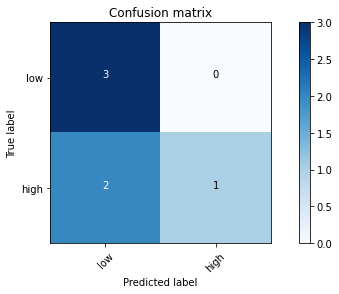

In [99]:
cm = confusion_matrix(labels_val, predicted_labels)
cm_plot_labels = ['low', 'high'] #['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)

## Save the model to DRIVE

In [ ]:
!tar -czf BERTmodel.tar.gz model
!mv BERTmodel.tar.gz ../drive/My\ Drive/Colab\ data/BERT/ 

## Test the model

In [ ]:
#multiple inputs
#用記事本打開csv文件，另存為设置編碼為utf-8
test_data_source = "data/test_data_0817.csv"
test_data_df = pd.read_csv(test_data_source, encoding='utf8', delimiter=',')
print(test_data_df.head())

   ID                                        Description  Class
0   0  - - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - -...    NaN
1   1                     --　　　　　　　　　　　　　　　　　　　　　    　--    NaN
2   2  版友們有哪些討厭的副作用呢？今天去運動途中哭了因為副作用讓我覺得沒辦法掌控自己的身體很痛苦 ...    NaN
3   3  「我會在，你放心。我們就慢慢把環境適應。」治療的最後，L說著，想要安撫我下週工作室搬遷的焦慮...    NaN
4   4  其實我也不知道在焦慮甚麼也許是不想有人來管吧?本來是社區自聘的管理員6/1起外包給保全公司我...    NaN


In [ ]:
test_data = list(test_data_df['Description'])
print(test_data[0])

- - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - - - - - - - - - - - -第一條　凡未分類、自創分類、未滿20字（不含標點符號）之文章，　　　　含有自殺、自殘、OD相關內容，未在標題加註「有雷」或「雷」者，　　　　初犯者板主將直接刪除文章，不另外公告或通知。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第二條　發文內容或推文大部分內容，違反中華民國法律者，　　　　初犯者板主將直接刪除文章並並水桶三日，不另外公告或通知。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第三條　尋死文、自殺文、自殘文、OD文、藥物徵求買賣文等違規文章，　　　　除自殺文暫保留二日以便板友關心追蹤外，其餘文直接刪除並水桶三日。　　　　解除水桶之後其發文仍未遵循板規者，其發文劣退並水桶一個月。　　　　水桶後無論自行發文或在其他板友文章內推文再犯者皆永久水桶。第四條　本板對人身攻擊定義，不論是主動攻擊他人或因對他人言論不滿而回擊者，　　　　只要構成人身攻擊之事實，即視為違規，依程度輕重照板規懲處。　　　　此外，意見不合與人身攻擊間有很大的落差，　　　　請發文推文者勿因他人持反對意見，就任意指責對方人身攻擊，　　　　如經板主認定檢舉人有濫訴之嫌，得以不回應其檢舉。　　　　　　　認定標準為：該字詞足以引起本板板友普遍性之不悅，並達到動怒的程度。　　　　例：「你根本不是憂鬱症吧！」、「會生病是你活該」等　　　　普通人身攻擊文劣退處理，並水桶一週；於推文中普通人身攻擊者水桶一週。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。　　　　　　　認定標準為：該字詞足以引起一般使用者普遍性之不悅，並達到動怒的程度。　　　　例：「你去死」、「吃屎吧你」等　　　　惡意人身攻擊文劣退處理，並水桶二週；於推文中惡意人身攻擊者水桶二週。　　　　其後發文或推文仍未改善者劣退水桶二個月。三犯永久水桶。　　　　　　　認定標準為：可能觸犯刑法公然侮辱罪，含三字經、不雅形容詞等用詞。　　　　例：「幹」、「醜」、「賤」、「智障」、「白痴」、「腦殘」、「丁丁」等。　　　　公然侮辱罪需針對特定人士辱罵才能成立，用以上詞彙評論事件，　　　　或是該文章、推文中無法推斷出發表者有針對特定人物，不構成公然侮辱罪。　　　　但若有符合上述普通、惡意

In [ ]:
test_results = getPrediction(test_data)
print("#"*50)
print(test_results[0])

INFO:tensorflow:Writing example 0 of 200


INFO:tensorflow:Writing example 0 of 200


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] - - - - - - - - - - - - - - 附 錄 ： 【 發 文 與 推 文 罰 則 】 - - - - - - - - - - - - - - 第 一 條 凡 未 分 類 、 自 創 分 類 、 未 滿 20 字 （ 不 含 標 點 符 號 ） 之 文 章 ， 含 有 自 殺 、 自 殘 、 [UNK] 相 關 內 容 ， 未 在 標 題 加 註 「 有 雷 」 或 「 雷 」 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 二 條 發 文 內 容 或 推 文 大 部 分 內 容 ， 違 反 中 華 民 國 法 律 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 並 並 水 桶 三 日 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 三 條 尋 死 文 、 自 殺 文 、 自 殘 文 、 [UNK] 文 、 藥 物 徵 求 買 賣 文 [SEP]


INFO:tensorflow:tokens: [CLS] - - - - - - - - - - - - - - 附 錄 ： 【 發 文 與 推 文 罰 則 】 - - - - - - - - - - - - - - 第 一 條 凡 未 分 類 、 自 創 分 類 、 未 滿 20 字 （ 不 含 標 點 符 號 ） 之 文 章 ， 含 有 自 殺 、 自 殘 、 [UNK] 相 關 內 容 ， 未 在 標 題 加 註 「 有 雷 」 或 「 雷 」 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 二 條 發 文 內 容 或 推 文 大 部 分 內 容 ， 違 反 中 華 民 國 法 律 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 並 並 水 桶 三 日 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 三 條 尋 死 文 、 自 殺 文 、 自 殘 文 、 [UNK] 文 、 藥 物 徵 求 買 賣 文 [SEP]


INFO:tensorflow:input_ids: 101 118 118 118 118 118 118 118 118 118 118 118 118 118 118 7353 7087 8038 523 4634 3152 5645 2972 3152 5391 1179 524 118 118 118 118 118 118 118 118 118 118 118 118 118 118 5018 671 3454 1127 3313 1146 7546 510 5632 1201 1146 7546 510 3313 4021 8113 2099 8020 679 1419 3560 7953 5016 5998 8021 722 3152 4995 8024 1419 3300 5632 3669 510 5632 3659 510 100 4685 7302 1058 2159 8024 3313 1762 3560 7539 1217 6263 519 3300 7440 520 2772 519 7440 520 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152 2772 2972 3152 793 3313 3121 1587 5442 1219 6842 3717 3446 671 943 3299 511 676 4306 3719 719 3717 3446 511 5018 753 3454 4634 3152 1058 2159 2772 2972 3152 1920 6956 1146 1058 2159 8024 6889 1353 704 5836 3696 1751 3791 2526 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 699 699 3717 3446 676 3189 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152

INFO:tensorflow:input_ids: 101 118 118 118 118 118 118 118 118 118 118 118 118 118 118 7353 7087 8038 523 4634 3152 5645 2972 3152 5391 1179 524 118 118 118 118 118 118 118 118 118 118 118 118 118 118 5018 671 3454 1127 3313 1146 7546 510 5632 1201 1146 7546 510 3313 4021 8113 2099 8020 679 1419 3560 7953 5016 5998 8021 722 3152 4995 8024 1419 3300 5632 3669 510 5632 3659 510 100 4685 7302 1058 2159 8024 3313 1762 3560 7539 1217 6263 519 3300 7440 520 2772 519 7440 520 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152 2772 2972 3152 793 3313 3121 1587 5442 1219 6842 3717 3446 671 943 3299 511 676 4306 3719 719 3717 3446 511 5018 753 3454 4634 3152 1058 2159 2772 2972 3152 1920 6956 1146 1058 2159 8024 6889 1353 704 5836 3696 1751 3791 2526 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 699 699 3717 3446 676 3189 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] - - - - [SEP]


INFO:tensorflow:tokens: [CLS] - - - - [SEP]


INFO:tensorflow:input_ids: 101 118 118 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 118 118 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 版 友 們 有 哪 些 討 厭 的 副 作 用 呢 ？ 今 天 去 運 動 途 中 哭 了 因 為 副 作 用 讓 我 覺 得 沒 辦 法 掌 控 自 己 的 身 體 很 痛 苦 悲 從 中 來 運 動 暫 時 可 以 忘 掉 但 一 想 到 眼 淚 就 冒 出 眼 眶 好 痛 苦 但 不 能 不 吃 藥 希 望 自 己 不 要 被 藥 物 綁 住 但 現 階 段 我 不 能 不 吃 藥 . . . 好 沮 喪 感 覺 連 掌 控 權 都 沒 有 「 妳 還 好 嗎 ？ 」 人 們 問 。 「 我 不 好 。 」 她 們 就 會 一 臉 尷 尬 的 沈 默 了 不 然 你 們 希 冀 什 麼 答 案 啊 ？ - - + 1 可 以 問 但 是 不 要 對 方 回 答 負 面 的 就 不 開 心 的 沈 默 . . . [UNK] 或 是 無 語 問 蒼 天 嗯 嗯 不 要 期 待 一 個 很 正 面 的 回 答 不 要 去 預 設 一 個 美 好 的 回 應 [SEP]


INFO:tensorflow:tokens: [CLS] 版 友 們 有 哪 些 討 厭 的 副 作 用 呢 ？ 今 天 去 運 動 途 中 哭 了 因 為 副 作 用 讓 我 覺 得 沒 辦 法 掌 控 自 己 的 身 體 很 痛 苦 悲 從 中 來 運 動 暫 時 可 以 忘 掉 但 一 想 到 眼 淚 就 冒 出 眼 眶 好 痛 苦 但 不 能 不 吃 藥 希 望 自 己 不 要 被 藥 物 綁 住 但 現 階 段 我 不 能 不 吃 藥 . . . 好 沮 喪 感 覺 連 掌 控 權 都 沒 有 「 妳 還 好 嗎 ？ 」 人 們 問 。 「 我 不 好 。 」 她 們 就 會 一 臉 尷 尬 的 沈 默 了 不 然 你 們 希 冀 什 麼 答 案 啊 ？ - - + 1 可 以 問 但 是 不 要 對 方 回 答 負 面 的 就 不 開 心 的 沈 默 . . . [UNK] 或 是 無 語 問 蒼 天 嗯 嗯 不 要 期 待 一 個 很 正 面 的 回 答 不 要 去 預 設 一 個 美 好 的 回 應 [SEP]


INFO:tensorflow:input_ids: 101 4276 1351 947 3300 1525 763 6245 1339 4638 1199 868 4500 1450 8043 791 1921 1343 6880 1240 6854 704 1526 749 1728 4158 1199 868 4500 6366 2769 6221 2533 3760 6794 3791 2958 2971 5632 2346 4638 6716 7768 2523 4578 5736 2650 2537 704 889 6880 1240 3271 3229 1377 809 2563 2957 852 671 2682 1168 4706 3907 2218 1088 1139 4706 4702 1962 4578 5736 852 679 5543 679 1391 5973 2361 3307 5632 2346 679 6206 6158 5973 4289 5192 857 852 4412 7389 3667 2769 679 5543 679 1391 5973 119 119 119 1962 3775 1603 2697 6221 6865 2958 2971 3609 6963 3760 3300 519 1986 6917 1962 1621 8043 520 782 947 1558 511 519 2769 679 1962 511 520 1961 947 2218 3298 671 5622 2220 2217 4638 3755 7949 749 679 4197 872 947 2361 1078 784 7938 5031 3428 1557 8043 118 118 116 122 1377 809 1558 852 3221 679 6206 2205 3175 1726 5031 6511 7481 4638 2218 679 7274 2552 4638 3755 7949 119 119 119 100 2772 3221 4192 6295 1558 5895 1921 1638 1638 679 6206 3309 2521 671 943 2523 3633 7481 4638 1726 5031 679

INFO:tensorflow:input_ids: 101 4276 1351 947 3300 1525 763 6245 1339 4638 1199 868 4500 1450 8043 791 1921 1343 6880 1240 6854 704 1526 749 1728 4158 1199 868 4500 6366 2769 6221 2533 3760 6794 3791 2958 2971 5632 2346 4638 6716 7768 2523 4578 5736 2650 2537 704 889 6880 1240 3271 3229 1377 809 2563 2957 852 671 2682 1168 4706 3907 2218 1088 1139 4706 4702 1962 4578 5736 852 679 5543 679 1391 5973 2361 3307 5632 2346 679 6206 6158 5973 4289 5192 857 852 4412 7389 3667 2769 679 5543 679 1391 5973 119 119 119 1962 3775 1603 2697 6221 6865 2958 2971 3609 6963 3760 3300 519 1986 6917 1962 1621 8043 520 782 947 1558 511 519 2769 679 1962 511 520 1961 947 2218 3298 671 5622 2220 2217 4638 3755 7949 749 679 4197 872 947 2361 1078 784 7938 5031 3428 1557 8043 118 118 116 122 1377 809 1558 852 3221 679 6206 2205 3175 1726 5031 6511 7481 4638 2218 679 7274 2552 4638 3755 7949 119 119 119 100 2772 3221 4192 6295 1558 5895 1921 1638 1638 679 6206 3309 2521 671 943 2523 3633 7481 4638 1726 5031 679

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 「 我 會 在 ， 你 放 心 。 我 們 就 慢 慢 把 環 境 適 應 。 」 治 療 的 最 後 ， [UNK] 說 著 ， 想 要 安 撫 我 下 週 工 作 室 搬 遷 的 焦 慮 。 當 下 覺 得 很 溫 暖 ， 很 放 心 地 微 笑 了 ， 可 是 我 現 在 卻 快 要 被 恐 懼 焦 慮 淹 沒 ， 因 為 [UNK] 也 給 過 我 太 多 承 諾 。 我 很 清 楚 [UNK] 和 [UNK] 是 截 然 不 同 的 ， [UNK] 是 會 員 是 候 選 人 ， 這 就 是 他 的 工 作 ， 所 以 他 會 在 。 這 些 我 都 知 道 ， 我 也 以 為 我 已 經 100 % 依 賴 [UNK] ， 是 可 以 懂 他 只 是 為 了 讓 我 安 心 ， 告 訴 我 他 會 在 新 的 工 作 室 等 著 我 過 去 。 可 是 我 現 在 焦 慮 到 想 吐 [UNK] 既 昨 天 腰 痛 之 後 今 天 多 了 背 痛 ， 一 定 又 是 重 訓 的 過 程 中 姿 勢 錯 誤 導 致 的 ， 但 重 點 是 我 不 知 道 問 題 在 哪 裡 > < 和 現 在 的 教 練 上 課 已 經 超 過 半 年 ， 然 而 [SEP]


INFO:tensorflow:tokens: [CLS] 「 我 會 在 ， 你 放 心 。 我 們 就 慢 慢 把 環 境 適 應 。 」 治 療 的 最 後 ， [UNK] 說 著 ， 想 要 安 撫 我 下 週 工 作 室 搬 遷 的 焦 慮 。 當 下 覺 得 很 溫 暖 ， 很 放 心 地 微 笑 了 ， 可 是 我 現 在 卻 快 要 被 恐 懼 焦 慮 淹 沒 ， 因 為 [UNK] 也 給 過 我 太 多 承 諾 。 我 很 清 楚 [UNK] 和 [UNK] 是 截 然 不 同 的 ， [UNK] 是 會 員 是 候 選 人 ， 這 就 是 他 的 工 作 ， 所 以 他 會 在 。 這 些 我 都 知 道 ， 我 也 以 為 我 已 經 100 % 依 賴 [UNK] ， 是 可 以 懂 他 只 是 為 了 讓 我 安 心 ， 告 訴 我 他 會 在 新 的 工 作 室 等 著 我 過 去 。 可 是 我 現 在 焦 慮 到 想 吐 [UNK] 既 昨 天 腰 痛 之 後 今 天 多 了 背 痛 ， 一 定 又 是 重 訓 的 過 程 中 姿 勢 錯 誤 導 致 的 ， 但 重 點 是 我 不 知 道 問 題 在 哪 裡 > < 和 現 在 的 教 練 上 課 已 經 超 過 半 年 ， 然 而 [SEP]


INFO:tensorflow:input_ids: 101 519 2769 3298 1762 8024 872 3123 2552 511 2769 947 2218 2714 2714 2828 4472 1862 6900 2746 511 520 3780 4615 4638 3297 2527 8024 100 6303 5865 8024 2682 6206 2128 3062 2769 678 6867 2339 868 2147 3021 6907 4638 4193 2719 511 4534 678 6221 2533 2523 3984 3265 8024 2523 3123 2552 1765 2544 5010 749 8024 1377 3221 2769 4412 1762 1320 2571 6206 6158 2607 2758 4193 2719 3922 3760 8024 1728 4158 100 738 5183 6882 2769 1922 1914 2824 6330 511 2769 2523 3926 3504 100 1469 100 3221 2779 4197 679 1398 4638 8024 100 3221 3298 1519 3221 952 6908 782 8024 6857 2218 3221 800 4638 2339 868 8024 2792 809 800 3298 1762 511 6857 763 2769 6963 4761 6887 8024 2769 738 809 4158 2769 2347 5195 8135 110 898 6552 100 8024 3221 1377 809 2743 800 1372 3221 4158 749 6366 2769 2128 2552 8024 1440 6260 2769 800 3298 1762 3173 4638 2339 868 2147 5023 5865 2769 6882 1343 511 1377 3221 2769 4412 1762 4193 2719 1168 2682 1402 100 3188 3219 1921 5587 4578 722 2527 791 1921 1914 749 5520 4

INFO:tensorflow:input_ids: 101 519 2769 3298 1762 8024 872 3123 2552 511 2769 947 2218 2714 2714 2828 4472 1862 6900 2746 511 520 3780 4615 4638 3297 2527 8024 100 6303 5865 8024 2682 6206 2128 3062 2769 678 6867 2339 868 2147 3021 6907 4638 4193 2719 511 4534 678 6221 2533 2523 3984 3265 8024 2523 3123 2552 1765 2544 5010 749 8024 1377 3221 2769 4412 1762 1320 2571 6206 6158 2607 2758 4193 2719 3922 3760 8024 1728 4158 100 738 5183 6882 2769 1922 1914 2824 6330 511 2769 2523 3926 3504 100 1469 100 3221 2779 4197 679 1398 4638 8024 100 3221 3298 1519 3221 952 6908 782 8024 6857 2218 3221 800 4638 2339 868 8024 2792 809 800 3298 1762 511 6857 763 2769 6963 4761 6887 8024 2769 738 809 4158 2769 2347 5195 8135 110 898 6552 100 8024 3221 1377 809 2743 800 1372 3221 4158 749 6366 2769 2128 2552 8024 1440 6260 2769 800 3298 1762 3173 4638 2339 868 2147 5023 5865 2769 6882 1343 511 1377 3221 2769 4412 1762 4193 2719 1168 2682 1402 100 3188 3219 1921 5587 4578 722 2527 791 1921 1914 749 5520 4

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 其 實 我 也 不 知 道 在 焦 慮 甚 麼 也 許 是 不 想 有 人 來 管 吧 ? 本 來 是 社 區 自 聘 的 管 理 員 6 / 1 起 外 包 給 保 全 公 司 我 也 確 定 留 任 了 可 是 從 得 知 消 息 之 後 還 是 一 樣 焦 慮 今 天 去 保 全 公 司 面 談 ， 填 了 一 堆 不 知 道 是 甚 麼 的 資 料 （ 這 點 很 危 險 ， 好 孩 子 不 要 學 ） 因 為 還 有 另 一 個 同 事 不 知 為 何 早 到 ， 保 全 公 司 的 說 要 一 起 解 釋 ， 所 以 我 不 好 意 思 讓 他 等 其 實 事 後 也 沒 有 甚 麼 解 釋 ， 很 多 事 沒 搞 清 楚 其 實 就 制 度 面 來 說 ， 有 公 司 會 比 較 好 至 少 以 後 勞 健 保 有 著 落 了 以 後 上 班 時 間 相 對 固 定 ， 輪 班 不 像 現 在 這 樣 常 常 日 夜 顛 倒 而 且 工 作 地 點 沒 變 ， 服 務 對 象 沒 變 但 一 想 到 上 面 突 然 多 了 陌 生 人 來 管 就 覺 得 莫 名 害 怕 上 次 這 樣 [SEP]


INFO:tensorflow:tokens: [CLS] 其 實 我 也 不 知 道 在 焦 慮 甚 麼 也 許 是 不 想 有 人 來 管 吧 ? 本 來 是 社 區 自 聘 的 管 理 員 6 / 1 起 外 包 給 保 全 公 司 我 也 確 定 留 任 了 可 是 從 得 知 消 息 之 後 還 是 一 樣 焦 慮 今 天 去 保 全 公 司 面 談 ， 填 了 一 堆 不 知 道 是 甚 麼 的 資 料 （ 這 點 很 危 險 ， 好 孩 子 不 要 學 ） 因 為 還 有 另 一 個 同 事 不 知 為 何 早 到 ， 保 全 公 司 的 說 要 一 起 解 釋 ， 所 以 我 不 好 意 思 讓 他 等 其 實 事 後 也 沒 有 甚 麼 解 釋 ， 很 多 事 沒 搞 清 楚 其 實 就 制 度 面 來 說 ， 有 公 司 會 比 較 好 至 少 以 後 勞 健 保 有 著 落 了 以 後 上 班 時 間 相 對 固 定 ， 輪 班 不 像 現 在 這 樣 常 常 日 夜 顛 倒 而 且 工 作 地 點 沒 變 ， 服 務 對 象 沒 變 但 一 想 到 上 面 突 然 多 了 陌 生 人 來 管 就 覺 得 莫 名 害 怕 上 次 這 樣 [SEP]


INFO:tensorflow:input_ids: 101 1071 2179 2769 738 679 4761 6887 1762 4193 2719 4493 7938 738 6258 3221 679 2682 3300 782 889 5052 1416 136 3315 889 3221 4852 1281 5632 5470 4638 5052 4415 1519 127 120 122 6629 1912 1259 5183 924 1059 1062 1385 2769 738 4825 2137 4522 818 749 1377 3221 2537 2533 4761 3867 2622 722 2527 6917 3221 671 3564 4193 2719 791 1921 1343 924 1059 1062 1385 7481 6312 8024 1856 749 671 1831 679 4761 6887 3221 4493 7938 4638 6536 3160 8020 6857 7953 2523 1314 7402 8024 1962 2111 2094 679 6206 2119 8021 1728 4158 6917 3300 1369 671 943 1398 752 679 4761 4158 862 3193 1168 8024 924 1059 1062 1385 4638 6303 6206 671 6629 6237 7026 8024 2792 809 2769 679 1962 2692 2590 6366 800 5023 1071 2179 752 2527 738 3760 3300 4493 7938 6237 7026 8024 2523 1914 752 3760 3018 3926 3504 1071 2179 2218 1169 2428 7481 889 6303 8024 3300 1062 1385 3298 3683 6733 1962 5635 2208 809 2527 1246 978 924 3300 5865 5862 749 809 2527 677 4408 3229 7279 4685 2205 1743 2137 8024 6743 4408 679 100

INFO:tensorflow:input_ids: 101 1071 2179 2769 738 679 4761 6887 1762 4193 2719 4493 7938 738 6258 3221 679 2682 3300 782 889 5052 1416 136 3315 889 3221 4852 1281 5632 5470 4638 5052 4415 1519 127 120 122 6629 1912 1259 5183 924 1059 1062 1385 2769 738 4825 2137 4522 818 749 1377 3221 2537 2533 4761 3867 2622 722 2527 6917 3221 671 3564 4193 2719 791 1921 1343 924 1059 1062 1385 7481 6312 8024 1856 749 671 1831 679 4761 6887 3221 4493 7938 4638 6536 3160 8020 6857 7953 2523 1314 7402 8024 1962 2111 2094 679 6206 2119 8021 1728 4158 6917 3300 1369 671 943 1398 752 679 4761 4158 862 3193 1168 8024 924 1059 1062 1385 4638 6303 6206 671 6629 6237 7026 8024 2792 809 2769 679 1962 2692 2590 6366 800 5023 1071 2179 752 2527 738 3760 3300 4493 7938 6237 7026 8024 2523 1914 752 3760 3018 3926 3504 1071 2179 2218 1169 2428 7481 889 6303 8024 3300 1062 1385 3298 3683 6733 1962 5635 2208 809 2527 1246 978 924 3300 5865 5862 749 809 2527 677 4408 3229 7279 4685 2205 1743 2137 8024 6743 4408 679 100

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


##################################################
('- - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - - - - - - - - - - - -第一條\u3000凡未分類、自創分類、未滿20字（不含標點符號）之文章，\u3000\u3000\u3000\u3000含有自殺、自殘、OD相關內容，未在標題加註「有雷」或「雷」者，\u3000\u3000\u3000\u3000初犯者板主將直接刪除文章，不另外公告或通知。\u3000\u3000\u3000\u3000其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第二條\u3000發文內容或推文大部分內容，違反中華民國法律者，\u3000\u3000\u3000\u3000初犯者板主將直接刪除文章並並水桶三日，不另外公告或通知。\u3000\u3000\u3000\u3000其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第三條\u3000尋死文、自殺文、自殘文、OD文、藥物徵求買賣文等違規文章，\u3000\u3000\u3000\u3000除自殺文暫保留二日以便板友關心追蹤外，其餘文直接刪除並水桶三日。\u3000\u3000\u3000\u3000解除水桶之後其發文仍未遵循板規者，其發文劣退並水桶一個月。\u3000\u3000\u3000\u3000水桶後無論自行發文或在其他板友文章內推文再犯者皆永久水桶。第四條\u3000本板對人身攻擊定義，不論是主動攻擊他人或因對他人言論不滿而回擊者，\u3000\u3000\u3000\u3000只要構成人身攻擊之事實，即視為違規，依程度輕重照板規懲處。\u3000\u3000\u3000\u3000此外，意見不合與人身攻擊間有很大的落差，\u3000\u3000\u3000\u3000請發文推文者勿因他人持反對意見，就任意指責對方人身攻擊，\u3000\u3000\u3000\u3000如經板主認定檢舉人有濫訴之嫌，得以不回應其檢舉。\u3000\u3000\u3000\u3000\u3000\u3000\u3000認定標準為：該字詞足以引起本板板友普遍性之不悅，並達到動怒的程度。\u3000\u3000\u3000\u3000例：「你根本不是憂鬱症吧！」、「會生病是

In [ ]:
results = [tr[2] for tr in test_results]
print(results)

[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]


In [ ]:
test_data_df['Predicted'] = results
test_data_df.to_csv('data/suicide_test_result.csv', encoding='utf8')

## Free test here

In [ ]:
#Classifying random sentences
test_results = getPrediction(['其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法',
                       '帶了很多藥來就是因為怕這樣的時刻又出現這才是真正的逢魔時刻吧想自我毀滅盡量躺著保持安靜再撐幾天就回家了沒事的',
                       '還有半小時覺得倦怠低落負面而自我放逐下班要吃冰冰彷彿是每天的救贖潰瘍還沒好',
                       '群組裡面都是很負面的話受不了就不要加入下輩子再見也可以說不定會好 '
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 其 實 我 本 來 就 不 太 想 活 了 每 次 和 媽 媽 說 完 話 我 就 開 始 辜 狗 自 殺 方 法 [SEP]


INFO:tensorflow:tokens: [CLS] 其 實 我 本 來 就 不 太 想 活 了 每 次 和 媽 媽 說 完 話 我 就 開 始 辜 狗 自 殺 方 法 [SEP]


INFO:tensorflow:input_ids: 101 1071 2179 2769 3315 889 2218 679 1922 2682 3833 749 3680 3613 1469 2061 2061 6303 2130 6282 2769 2218 7274 1993 6790 4318 5632 3669 3175 3791 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1071 2179 2769 3315 889 2218 679 1922 2682 3833 749 3680 3613 1469 2061 2061 6303 2130 6282 2769 2218 7274 1993 6790 4318 5632 3669 3175 3791 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 帶 了 很 多 藥 來 就 是 因 為 怕 這 樣 的 時 刻 又 出 現 這 才 是 真 正 的 逢 魔 時 刻 吧 想 自 我 毀 滅 盡 量 躺 著 保 持 安 靜 再 撐 幾 天 就 回 家 了 沒 事 的 [SEP]


INFO:tensorflow:tokens: [CLS] 帶 了 很 多 藥 來 就 是 因 為 怕 這 樣 的 時 刻 又 出 現 這 才 是 真 正 的 逢 魔 時 刻 吧 想 自 我 毀 滅 盡 量 躺 著 保 持 安 靜 再 撐 幾 天 就 回 家 了 沒 事 的 [SEP]


INFO:tensorflow:input_ids: 101 2380 749 2523 1914 5973 889 2218 3221 1728 4158 2586 6857 3564 4638 3229 1174 1348 1139 4412 6857 2798 3221 4696 3633 4638 6864 7795 3229 1174 1416 2682 5632 2769 3672 3994 4674 7030 6720 5865 924 2898 2128 7477 1086 3052 2407 1921 2218 1726 2157 749 3760 752 4638 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2380 749 2523 1914 5973 889 2218 3221 1728 4158 2586 6857 3564 4638 3229 1174 1348 1139 4412 6857 2798 3221 4696 3633 4638 6864 7795 3229 1174 1416 2682 5632 2769 3672 3994 4674 7030 6720 5865 924 2898 2128 7477 1086 3052 2407 1921 2218 1726 2157 749 3760 752 4638 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 還 有 半 小 時 覺 得 倦 怠 低 落 負 面 而 自 我 放 逐 下 班 要 吃 冰 冰 彷 彿 是 每 天 的 救 贖 潰 瘍 還 沒 好 [SEP]


INFO:tensorflow:tokens: [CLS] 還 有 半 小 時 覺 得 倦 怠 低 落 負 面 而 自 我 放 逐 下 班 要 吃 冰 冰 彷 彿 是 每 天 的 救 贖 潰 瘍 還 沒 好 [SEP]


INFO:tensorflow:input_ids: 101 6917 3300 1288 2207 3229 6221 2533 958 2591 856 5862 6511 7481 5445 5632 2769 3123 6852 678 4408 6206 1391 1102 1102 2513 2517 3221 3680 1921 4638 3131 6562 4061 4598 6917 3760 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6917 3300 1288 2207 3229 6221 2533 958 2591 856 5862 6511 7481 5445 5632 2769 3123 6852 678 4408 6206 1391 1102 1102 2513 2517 3221 3680 1921 4638 3131 6562 4061 4598 6917 3760 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 群 組 裡 面 都 是 很 負 面 的 話 受 不 了 就 不 要 加 入 下 輩 子 再 見 也 可 以 說 不 定 會 好 [SEP]


INFO:tensorflow:tokens: [CLS] 群 組 裡 面 都 是 很 負 面 的 話 受 不 了 就 不 要 加 入 下 輩 子 再 見 也 可 以 說 不 定 會 好 [SEP]


INFO:tensorflow:input_ids: 101 5408 5175 6174 7481 6963 3221 2523 6511 7481 4638 6282 1358 679 749 2218 679 6206 1217 1057 678 6742 2094 1086 6210 738 1377 809 6303 679 2137 3298 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5408 5175 6174 7481 6963 3221 2523 6511 7481 4638 6282 1358 679 749 2218 679 6206 1217 1057 678 6742 2094 1086 6210 738 1377 809 6303 679 2137 3298 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
test_results

[('其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法',
  array([-4.2940416 , -0.01525544, -6.508965  ], dtype=float32),
  1,
  'medium'),
 ('帶了很多藥來就是因為怕這樣的時刻又出現這才是真正的逢魔時刻吧想自我毀滅盡量躺著保持安靜再撐幾天就回家了沒事的',
  array([-4.380038  , -0.01521951, -5.9602184 ], dtype=float32),
  1,
  'medium'),
 ('還有半小時覺得倦怠低落負面而自我放逐下班要吃冰冰彷彿是每天的救贖潰瘍還沒好',
  array([-3.3580725 , -0.03784102, -6.06114   ], dtype=float32),
  1,
  'medium'),
 ('群組裡面都是很負面的話受不了就不要加入下輩子再見也可以說不定會好 ',
  array([-1.7969489 , -0.18484534, -5.821481  ], dtype=float32),
  1,
  'medium')]

Reference: https://analyticsindiamag.com/step-by-step-guide-to-implement-multi-class-classification-with-bert-tensorflow/